## Homework 6: Intermarket prediction
### FINM 33150 (Winter 2025) - Quantitative Trading Strategies
#### NAME: Arturo Charleston
#### Student ID: 12449584

## Introduction
In this notebook, I perform a 2-stage regression to predict hedged CDS returns from lagged idiosyncratic equity returns.

Credit Default Swaps (CDS) can be viewed as insurance against a firm’s default risk. **Movement in CDS spreads** is often regarded as a real-time reflection of credit market sentiment. Meanwhile, **equity returns** capture both systematic and firm-specific shifts in valuation. 

In this homework, I investigate whether **residual equity returns** provide a leading indicator for **future changes in CDS spreads**. I implement a **two-stage regression** approach:

1. **Stage 1 (Contemporaneous)**: Model equity returns and CDS returns to filter out market-driven movements and capture the hedged/residual returns $\rho$.  
2. **Stage 2 (Predictive)**: Use lagged, residual equity returns to predict the next period’s hedged/residual CDS returns.


In [1]:
# PACKAGES
import os
import warnings
import nasdaqdatalink
import statsmodels.api as sm
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import matplotlib.pyplot as plt
from pyprojroot import here

# Global Options
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

# Set directory
home_directory = "/Users/charleston/Downloads/git_repositories/finm-qts-2025"
os.chdir(home_directory)

# KEYS
from config import FRED_KEY
from config import QUANDL_KEY

nasdaqdatalink.ApiConfig.api_key = QUANDL_KEY

#from my_functions import *

# Dates
start_date = '2018-01-01'
end_date = "2024-12-31"

### Functions

In [2]:
def rolling_regression(y, X, window, add_const=False, return_preds=False, return_resid=False):

    y = np.asarray(y)
    X = np.asarray(X)
    if add_const:
        X = sm.add_constant(X)
        
    # RollingOLS: note that the first (window-1) observations will be NaN.
    model = RollingOLS(y, X, window=window)
    res = model.fit()
    
    beta = res.params  # DataFrame of rolling coefficients
    preds, resid = None, None
    if return_preds:
        # X_valid: only the rows corresponding to valid (non-NaN) beta coefficients.
        X_valid = X[window - 1:]
        # Extract the valid coefficients from beta.
        if hasattr(beta, "iloc"):
            beta_valid = beta.iloc[window - 1:].to_numpy()
        else:
            beta_valid = beta[window - 1:]
        
        # Now the shapes should match: both X_valid and beta_valid have shape (n - window + 1, n_predictors).
        preds_array = (X_valid * beta_valid).sum(axis=1)
        preds = pd.Series(preds_array, index=range(window - 1, len(y)))
        
        if return_resid:
            # Residuals: difference between actual y (valid part) and predictions.
            resid_array = y[window - 1:] - preds_array
            resid = pd.Series(resid_array, index=range(window - 1, len(y)))
    
    return beta, preds, resid

def discounted_least_squares(y, X, half_life, add_const=True):

    y = np.asarray(y)
    X = np.asarray(X)
    if add_const:
        X = sm.add_constant(X)
    
    n = len(y)
    # Create weights: the most recent observation gets weight 1, and
    # the weight decays exponentially for older observations.
    indices = np.arange(n)
    weights = np.exp(-np.log(2) * (n - 1 - indices) / half_life)
    
    model = sm.WLS(y, X, weights=weights)
    results = model.fit()
    return results

def rolling_discounted_least_squares(y, X, window, half_life, add_const=True,
                                       return_preds=False, return_resid=False):
    
    # Ensure y and X are numpy arrays.
    y = np.asarray(y)
    X = np.asarray(X)
    
    # Create rolling windows.
    y_roll = sliding_window_view(y, window_shape=window)             # shape: (n_windows, window)
    X_roll = sliding_window_view(X, window_shape=window, axis=0)       # expected shape: (n_windows, window, n_predictors)
    n_windows = y_roll.shape[0]
    
    coeff_list = []
    pred_list = []
    resid_list = []
    
    for i in range(n_windows):
        # Convert the current windows to standard contiguous arrays.
        y_window = np.array(y_roll[i])      # expected shape: (window,)
        X_window = np.array(X_roll[i])      # might be (window, n_predictors) or (n_predictors, window)
        
        # Check if X_window has the wrong orientation and transpose if needed.
        if X_window.shape[0] != window:
            X_window = X_window.T
        
        # Optional: Check that the window lengths match.
        if y_window.shape[0] != X_window.shape[0]:
            raise ValueError(f"Mismatch in window shapes: y_window shape {y_window.shape} vs X_window shape {X_window.shape}")
        
        # Fit discounted LS on the current window.
        res = discounted_least_squares(y_window, X_window, half_life, add_const=add_const)
        params = res.params
        coeff_list.append(params)
        
        if return_preds or return_resid:
            # Prepare the last observation for prediction.
            X_last = X_window[-1].reshape(1, -1)
            if add_const:
                X_last = sm.add_constant(X_last, has_constant='add')
            pred_val = np.dot(X_last, params)
            pred_list.append(pred_val[0])
            if return_resid:
                resid_list.append(y_window[-1] - pred_val[0])
    
    # Align the output with the last observation of each window.
    output_index = np.arange(window - 1, len(y))
    
    # Build a DataFrame for coefficients.
    coeff_array = np.vstack(coeff_list)
    if add_const:
        col_names = ['const'] + [f"x{i}" for i in range(1, X.shape[1] + 1)]
    else:
        col_names = [f"x{i}" for i in range(1, X.shape[1] + 1)]
    coeff_df = pd.DataFrame(coeff_array, index=output_index, columns=col_names)
    
    preds_series = pd.Series(pred_list, index=output_index) if return_preds else None
    resid_series = pd.Series(resid_list, index=output_index) if return_resid else None
    
    return coeff_df, preds_series, resid_series

def calculate_return_metrics(df, adj=12, adjusted = True, quantile = 0.05):

    results_df = pd.DataFrame(index=df.columns)
    if adjusted == True:
        results_df['Annualized Return'] = df.mean() * adj
        results_df['Annualized Volatility'] = df.std() * np.sqrt(adj)
    else:
        results_df['Annualized Return'] = df.mean()
        results_df['Annualized Volatility'] = df.std()

    # This works if you are calculating excess returns
    results_df['Sharpe Ratio'] = results_df['Annualized Return'] / results_df['Annualized Volatility']

    # Include skewness
    results_df['Skewness'] = df.skew()
    # Include Value at Risk
    results_df[f"VaR ({quantile})"] = df.quantile(quantile, axis=0)

    wealth_index = 1000 * (1 + df).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    results_df["Max Drawdown"] = drawdowns.min()

    # Include Kurtosis
    results_df["Excess Kurtosis"] = df.kurtosis()
    
    # Handling Sortino Ratio: avoid dividing by zero
    downside_std = df[df < 0].std()
    results_df['Annualized Sortino Ratio'] = results_df['Annualized Return'] / (downside_std * np.sqrt(adj)) if not downside_std.empty else np.nan

    return results_df

def compute_signals(pred_df, q_up, q_low):
    # Compute thresholds for each date.
    upper_threshold = pred_df.quantile(q=q_up, axis=1)
    lower_threshold = pred_df.quantile(q=q_low, axis=1)
    
    # Initialize a DataFrame to hold signals (same shape as pred_df).
    signals = pd.DataFrame(0, index=pred_df.index, columns=pred_df.columns)
    
    # For each date, assign a signal to each ticker.
    for date in pred_df.index:
        # Long if predicted > upper threshold; short if predicted < lower threshold.
        signals.loc[date] = np.where(
            pred_df.loc[date] > upper_threshold.loc[date], 1,
            np.where(pred_df.loc[date] < lower_threshold.loc[date], -1, 0)
        )
    return signals

def compute_quantile_strategy_returns(pred_df, actual_df, q_up, q_low):
    # Compute the daily (cross-sectional) thresholds.
    upper_threshold = pred_df.quantile(q=q_up, axis=1)
    lower_threshold = pred_df.quantile(q=q_low, axis=1)
    
    # Create a DataFrame to hold signals.
    signals = pd.DataFrame(0, index=pred_df.index, columns=pred_df.columns)
    
    # Loop over dates and assign signals.
    for date in pred_df.index:
        signals.loc[date] = np.where(
            pred_df.loc[date] > upper_threshold.loc[date],
            1,
            np.where(pred_df.loc[date] < lower_threshold.loc[date], -1, 0)
        )
    
    # Compute strategy returns: signal * actual residual returns.
    strat_returns = signals * actual_df
    # Average across tickers to get a single time series.
    strat_returns_avg = strat_returns.mean(axis=1)
    return strat_returns_avg

def compute_strategy_predictions_boxcar(G):
    pred_dict = {}
    for ticker in tickers:
        # Dependent: actual residual return.
        y = residual_returns[ticker]
        # Predictor: one-week lagged residual equity return.
        predictor = residual_equity_returns[ticker].shift(1)
        # Align series.
        common_dates = y.dropna().index.intersection(predictor.dropna().index)
        y = y.loc[common_dates]
        predictor = predictor.loc[common_dates]
        # Run rolling regression (Boxcar OLS).
        mu_box, _, _ = rolling_regression(
            y=y,
            X=predictor.values.reshape(-1, 1),
            window=G,
            add_const=False,
            return_preds=False,
            return_resid=False
        )
        if hasattr(mu_box, 'iloc'):
            mu_box_valid = mu_box.iloc[G-1:, 0].values
        else:
            mu_box_valid = mu_box[G-1:, 0]
        # Set valid dates to be the last n_valid dates of y.
        n_valid = len(mu_box_valid)
        valid_dates = y.index[-n_valid:]
        # Predicted residual = mu * current predictor.
        pred_series = pd.Series(mu_box_valid * predictor.loc[valid_dates].values, index=valid_dates, name=ticker)
        pred_dict[ticker] = pred_series
    df_pred = pd.concat(pred_dict, axis=1)
    return df_pred

def compute_strategy_predictions_dls(G, H):
    pred_dict = {}
    for ticker in tickers:
        y = residual_returns[ticker]
        predictor = residual_equity_returns[ticker].shift(1)
        common_dates = y.dropna().index.intersection(predictor.dropna().index)
        y = y.loc[common_dates]
        predictor = predictor.loc[common_dates]
        mu_dls, _, _ = rolling_discounted_least_squares(
            y=y.to_numpy(),
            X=predictor.to_numpy().reshape(-1, 1),
            window=G,
            half_life=H,
            add_const=False,
            return_preds=False,
            return_resid=False
        )
        if hasattr(mu_dls, 'iloc'):
            mu_dls_valid = mu_dls.iloc[G-1:, 0].values
        else:
            mu_dls_valid = mu_dls[G-1:, 0]
        n_valid = len(mu_dls_valid)
        valid_dates = y.index[-n_valid:]
        pred_series = pd.Series(mu_dls_valid * predictor.loc[valid_dates].values, index=valid_dates, name=ticker)
        pred_dict[ticker] = pred_series
    df_pred = pd.concat(pred_dict, axis=1)
    return df_pred

def compute_strategy_returns_from_predictions(df_pred):
    df_actual = residual_returns.loc[df_pred.index, df_pred.columns]
    signals = compute_signals(df_pred, q_up=0.60, q_low=0.40)
    strat_returns = signals * df_actual
    return strat_returns


## Data Overview
1. **Equity Data**: Weekly returns derived from adjusted close prices.  
2. **CDS Data**: Weekly changes in 5-year CDS spreads. Note that instead of taking the percentage increase, I am taking the difference because the spread are already in percentages, so we should take the change in the percentage.   
3. **Market Return**: A broad index (like SPY), noted as `m`.  
4. **CDS Index**: Averaged weekly CDS changes $r^{Index}$ across all tickers.  

I use rolling or exponentially weighted regressions to capture changing market conditions over time. 

- The data presents some particular characteristics
1. **Fat tails** in the distribution of CDS changes, especially during extreme market events (e.g., 2020 COVID).
2. Tickers like **Ford (F)** and **General Electric (GE)** that show **markedly higher volatility** in 2020, likely driven by heightened credit concerns.


### Data Preparing

- Read the Credit Default Swaps data, and keep only those tickers without missing values. These tickers are NFLX and DD. 
- Then, I convert the data into a wide format with the parspread column (CDS spread) and compute the Wednesday to Wednesday weekly returns on the CDS spread
- The weekly return is computed as the **difference** in spreads instead of the percentage increase because the spreads are already in percentage terms. 
- For the tickers that we have CDS data, I download from QUANDL EOD prices the End of day prices, and I compute the Wednesday to Wednesday weekly returns. 
- The weekly returns for the equity is calculated as the Week to Week percentage increase. 
- I also download SPY ETF End of Day prices to create the market equity returns for the market beta. 
- Then, I create the CDS index by simply taking the average of the CDS weekly returns. 

In [3]:
# Read CDS data
cds = pd.read_csv(here('./data/Liq5YCDS.delim'), delimiter='\t', usecols=lambda column: column not in ['Unnamed: 0'])
cds['date'] = pd.to_datetime(cds['date'])
cds = cds.set_index('date')
cds = cds[~cds['ticker'].isin(['NFLX', 'DD'])]

tickers = cds['ticker'].unique()

# Convert CDS data from long format to wide format, keeping only the 'parspread' column
cds = cds.pivot_table(index='date', columns='ticker', values='parspread')

cds_returns = cds.resample('W-WED').last().diff()
cds_returns.dropna(how='all', inplace=True)

In [4]:
# Read the stock data for each ticker
tickers_data_list = []

for ticker in np.append(tickers, 'SPY'):
    data = nasdaqdatalink.get_table(
        'QUOTEMEDIA/PRICES',
        date={'gte': start_date, 'lte': end_date},  # Specify start and end dates
        ticker=ticker,                             # Pass the ticker
        paginate=True
    )
    tickers_data_list.append(data[['date', 'ticker', 'adj_close']])

# Concatenate all the dataframes into one
tickers_data = pd.concat(tickers_data_list).sort_values(by='date')

# Convert from long format to wide format
tickers_data = tickers_data.pivot(index='date', columns='ticker', values='adj_close')

tickers_returns = tickers_data.resample('W-WED').last().pct_change()
tickers_returns.dropna(how='all', inplace=True)

In [5]:
# Calculate the cds_index as the average of the cds returns across different cds
cds_index = cds_returns.mean(axis=1)

cds_index= pd.DataFrame(cds_index, columns=['cds_index'])

cds_index.dropna(how='all', inplace=True)

## Regression Setup & Observations

### Stage 1: Contemporaneous Hedging
- **Equity CAPM**: Model $r^{Equity}$ vs. market `m` to remove broad equity risk.  
- **CDS Regressor**: Model $r^{CDS}$ vs. ($r^{Equity} + r^{Index}$) to remove overall equity/CDS index effects.  
- **Residual (Hedged) CDS Return** ($\rho$): Defined as the difference between actual CDS movement and the fitted value from the above regression.  
  - Typically **mean zero**, but can show **large outliers** (fat tails), especially in turbulent periods (like early 2020).

### Stage 2: Predictive Regression
- **Lagged Equity Residual** ($c_{E}$) = $r^{Equity} - \gamma*m$.  
- Regress $\rho$ on $c_{E, t-1}$ to see if **idiosyncratic equity moves** lead CDS changes: $\rho_{E,n} = \mu_{E,n}c_{E,n-1}$
  
- Compare **Boxcar OLS** (simple rolling window) and **Discounted LS** (exponential decay).  
  - We often see that **Discounted LS** adapts more quickly, leading to **better performance** in dynamic markets.


## Contemporaneous Models
- I perform contemporaneous regressions using boxcar OLS and Exponentially Decaying with a Window size of 20, and 10 respectively without intercept. 
- I estimate G week boxcar OLS of the equity returns and the market indicator to estimate the CAPM. $r_{E}^{Equity} = r^{Market} + \epsilon$. And denote the Market Beta of the n-th row as $\gamma_{E}^{n}$
- I estimate G week boxcar OLS of the CDS returns model using a 2 factor model. $r_{E}^{CDS} = r_{E}^{Equity} + r^{Index} + \epsilon$
- Based on the 2 Factor CDS return model, we calculate the predicted values and call them the *Hedge Portfolio returns*. $f_{E,n} = \beta_{E, Equity}^{(n)}r_{E,n}^{Equity} + \beta_{E, Index}^{(n)}r_{n}^{Index}$ 
- Then, I compute the 2 Factor CDS return model residuals and call them the *residual return* $\rho_{E,n} = r_{E, n}^{CDS} - f_{E,n}$
- I also define the *residual equity return* as $c_{E, n} = r_{E,n}^{Equity} - \gamma_{E, n}m_{n}$

In [6]:
# --- Parameters ---
G = 20   # Rolling window size (weeks)
H = 10   # Half-life (weeks) for exponential decay weights

capm_list = []         # For CAPM beta (slope) series, one column per ticker.
cds_boxcar_list = []   # For CDS Boxcar regression coefficients (2 predictors) per ticker.

for ticker in tickers:
    # -----------------------------------------
    # 1. CAPM Model for Equity Returns:
    #    Model: r_equity ~ m   
    # -----------------------------------------
    y_equity = tickers_returns[ticker]
    m = tickers_returns['SPY']  # Market returns
    # Reshape m to 2D array for regression.
    X_capm = m.values.reshape(-1, 1)
    
    # Run rolling OLS for CAPM 
    capm_beta, _, _ = rolling_regression(
        y=y_equity,
        X=X_capm,
        window=G,
        add_const=False,   
        return_preds=True,
        return_resid=True
    )
    # Our function returns "beta" for all observations (with the first G-1 rows typically invalid).
    # We take only the valid part, and reassign the date index.
    valid_dates_capm = y_equity.index[G-1:]
    # If beta is a DataFrame (or can be sliced like one), extract the first (and only) column.
    if hasattr(capm_beta, 'iloc'):
        capm_series = pd.Series(capm_beta.iloc[G-1:, 0].values, index=valid_dates_capm, name=ticker)
    else:
        capm_series = pd.Series(capm_beta[G-1:, 0], index=valid_dates_capm, name=ticker)
    
    capm_list.append(capm_series)
    
    # -----------------------------------------------------------
    # 2. CDS Model: Predicting CDS Spread Returns:
    #    Model: r_cds ~ r_equity + r_index
    # -----------------------------------------------------------
    y_cds = cds_returns[ticker]
    # Build predictors DataFrame.
    X_cds = pd.DataFrame({
        'r_equity': tickers_returns[ticker],
        'r_index': cds_index['cds_index']
    })
    
    # (A) Boxcar (rolling OLS) regression for CDS model.
    cds_boxcar_beta, _, _ = rolling_regression(
        y=y_cds,
        X=X_cds,
        window=G,
        add_const=False,   
        return_preds=True,
        return_resid=True
    )
    valid_dates_cds = y_cds.index[G-1:]
    # The returned beta may have lost column names since we converted to arrays.
    # We reconstruct a DataFrame with the appropriate column names.
    if hasattr(cds_boxcar_beta, 'iloc'):
        beta_boxcar = pd.DataFrame(cds_boxcar_beta.iloc[G-1:], index=valid_dates_cds, 
                                    columns=['r_equity', 'r_index'])
    else:
        beta_boxcar = pd.DataFrame(cds_boxcar_beta[G-1:], index=valid_dates_cds,
                                    columns=['r_equity', 'r_index'])
    # Rename columns to include the ticker identifier.
    beta_boxcar.rename(columns={'r_equity': ticker + '_r_equity',
                                'r_index': ticker + '_r_index'}, inplace=True)
    cds_boxcar_list.append(beta_boxcar)
    

# 1. CAPM DataFrame: rows = dates, columns = tickers (each cell is the rolling beta from r_equity ~ m).
df_capm = pd.concat(capm_list, axis=1)

# 2. CDS Boxcar DataFrame: rows = dates, columns = for each ticker two columns (ticker_r_equity and ticker_r_index).
df_cds_boxcar = pd.concat(cds_boxcar_list, axis=1)

In [7]:
# First, identify the common date index among all series.
common_index = (
    df_cds_boxcar.index
    .intersection(tickers_returns.index)
    .intersection(cds_index.index)
    .intersection(cds_returns.index)
    .intersection(df_capm.index)
)

# 1. Hedge Portfolio Returns:
#    f_{E,n} = beta^{(n)}_{E,Equity} * r^{Equity}_{E,n} + beta^{(n)}_{E,Index} * r^{Index}_{n}
hedged_returns = pd.DataFrame(index=common_index)

# 2. CDS Residual Returns:
#    ρ_{E,n} = r^{CDS}_{E,n} - f_{E,n}
residual_returns = pd.DataFrame(index=common_index)

# 3. Residual Equity Returns:
#    c_{E,n} = r^{Equity}_{E,n} - γ_{E,n} * m_n
# Here, df_capm contains the CAPM beta (γ) for each ticker from the regression of
# r^{Equity}_{E} ~ m, and m is the SPY return.
residual_equity_returns = pd.DataFrame(index=common_index)

for ticker in tickers:
    # The contemporaneous CDS model betas are stored in df_cds_boxcar,
    # with column names formatted as "{ticker}_r_equity" and "{ticker}_r_index".
    equity_beta = df_cds_boxcar.loc[common_index, f"{ticker}_r_equity"]
    index_beta  = df_cds_boxcar.loc[common_index, f"{ticker}_r_index"]
    
    # r^{Equity}_{E,n} for ticker and r^{Index}_{n} from the CDS index
    equity_return = tickers_returns.loc[common_index, ticker]
    cds_index_return = cds_index.loc[common_index, "cds_index"]
    
    # Compute the hedge portfolio return for ticker E.
    hedged_returns[ticker] = equity_beta * equity_return + index_beta * cds_index_return

    # Compute the CDS residual return for ticker E.
    residual_returns[ticker] = cds_returns.loc[common_index, ticker] - hedged_returns[ticker]

    # Compute the residual equity return for ticker E.
    gamma = df_capm.loc[common_index, ticker]  # CAPM beta (γ_{E,n})
    equity_return = tickers_returns.loc[common_index, ticker]
    market_return = tickers_returns.loc[common_index, 'SPY']
    
    residual_equity_returns[ticker] = equity_return - gamma * market_return


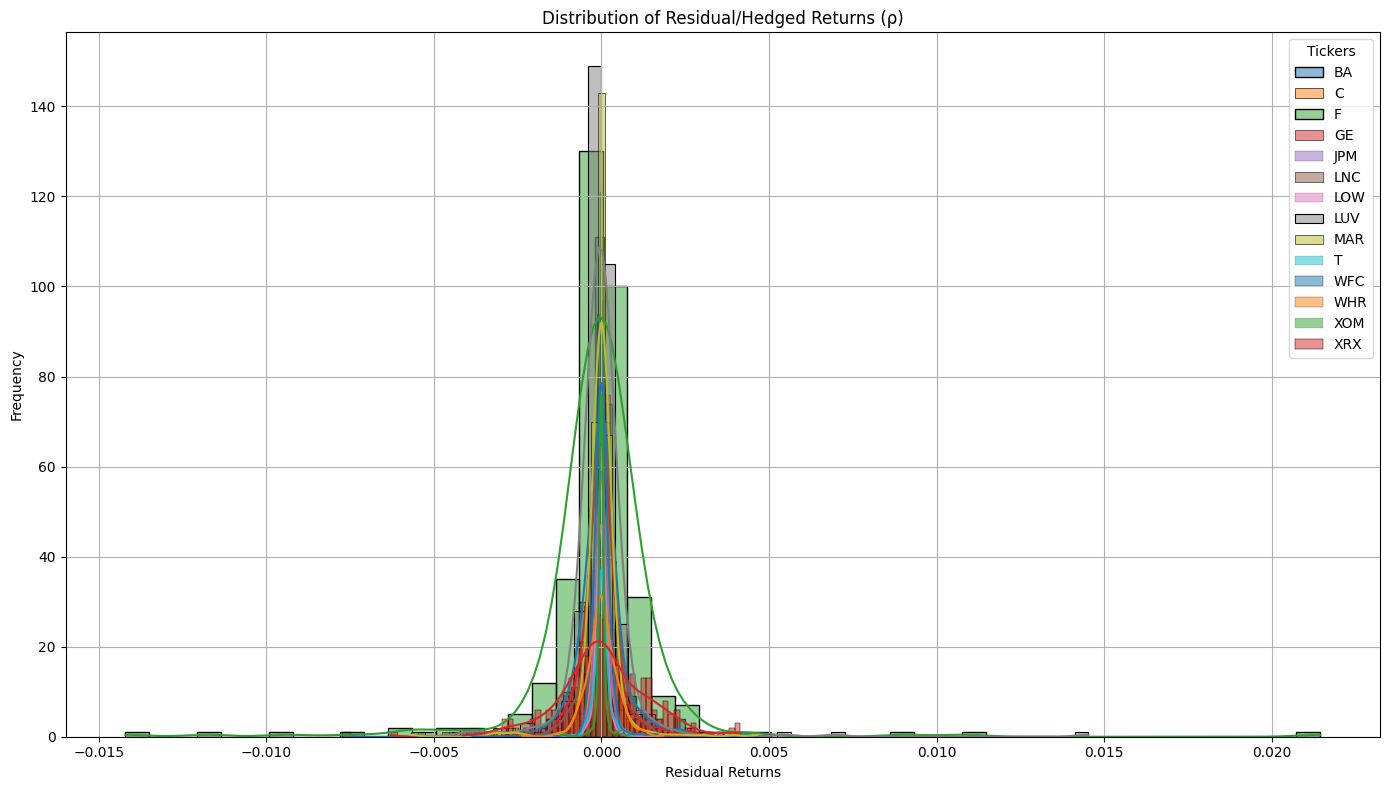

In [8]:
# Plot the distribution of residual returns for each ticker in one overlapped plot
plt.figure(figsize=(14, 8))
for ticker in residual_returns.columns:
    sns.histplot(residual_returns[ticker], bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Residual/Hedged Returns (ρ)')
plt.xlabel('Residual Returns')
plt.ylabel('Frequency')
plt.legend(title='Tickers')
plt.grid(True)
plt.tight_layout()
plt.show()

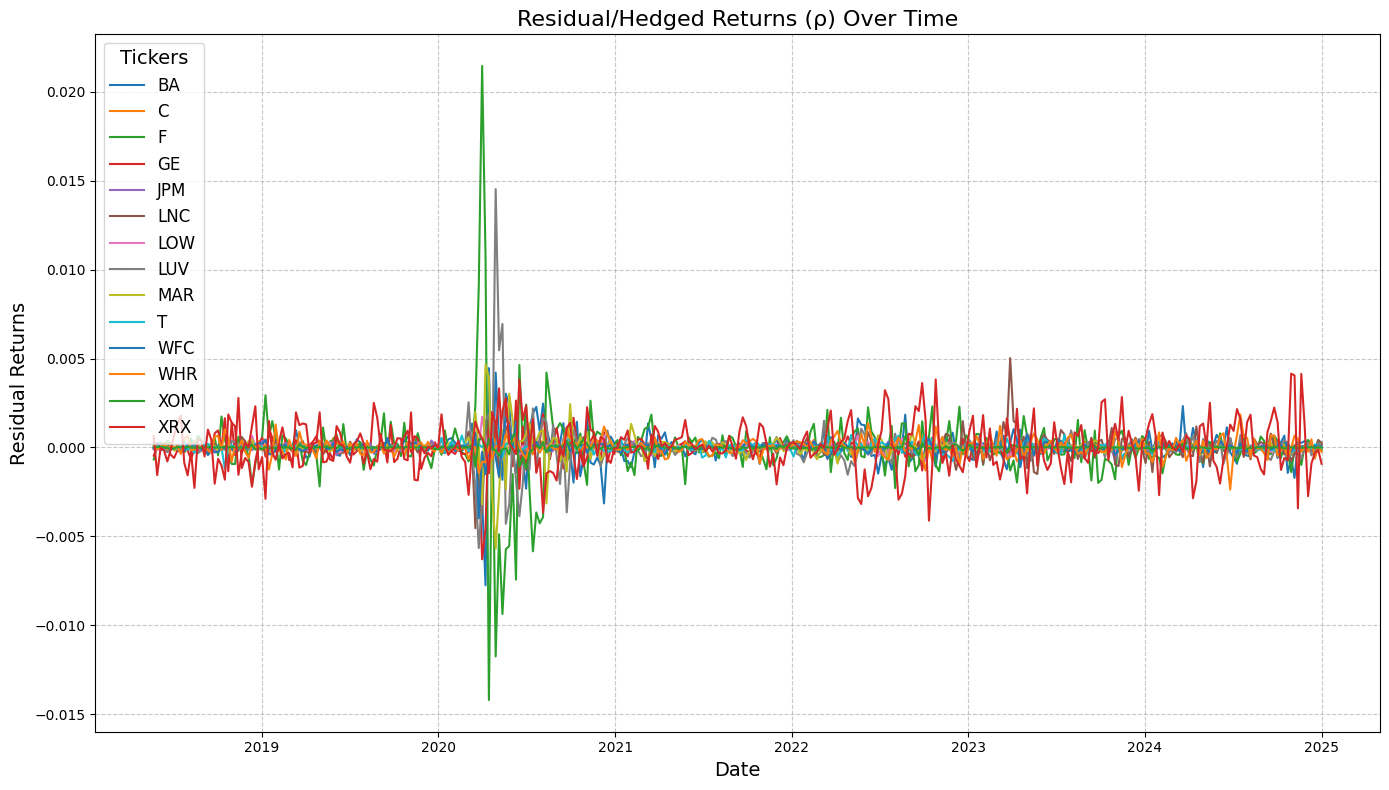

In [9]:
plt.figure(figsize=(14, 8))
for ticker in residual_returns.columns:
    plt.plot(residual_returns.index, residual_returns[ticker], label=ticker)

plt.title('Residual/Hedged Returns (ρ) Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual Returns', fontsize=14)
plt.legend(title='Tickers', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

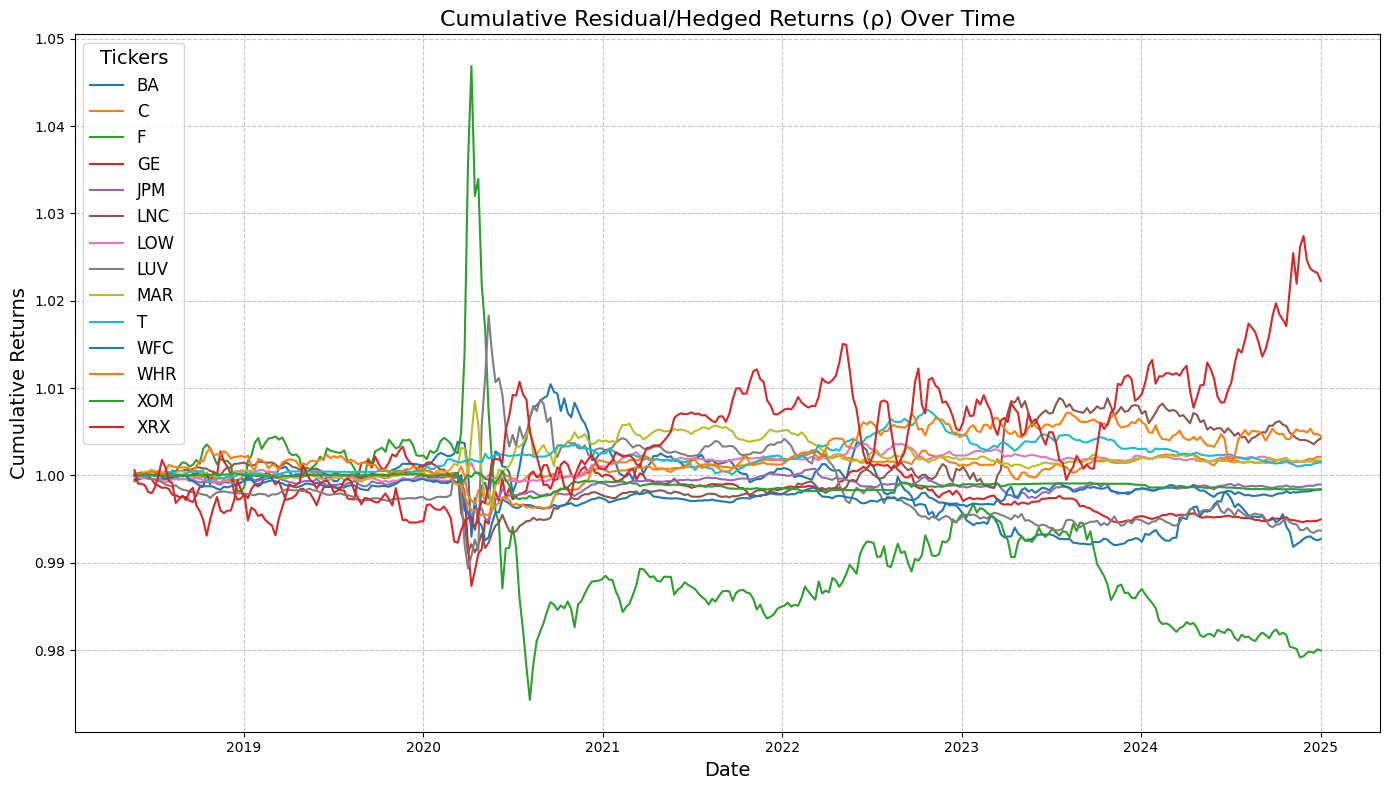

In [10]:
# Calculate cumulative returns
cumulative_returns = (1+residual_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)

plt.title('Cumulative Residual/Hedged Returns (ρ) Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.legend(title='Tickers', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

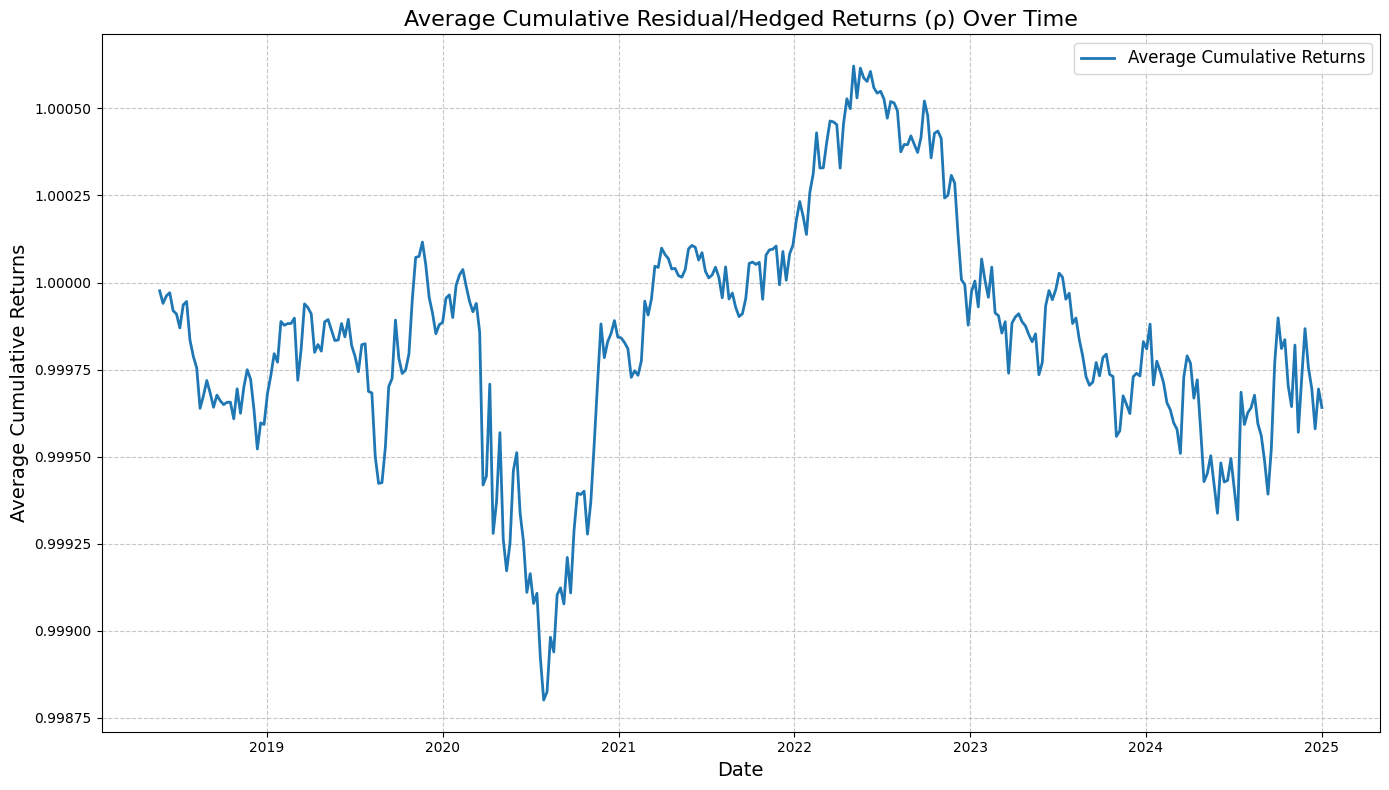

In [11]:
# Calculate the average cumulative returns across all tickers
average_cumulative_returns = cumulative_returns.mean(axis=1)

# Plot the average cumulative returns
plt.figure(figsize=(14, 8))
plt.plot(average_cumulative_returns.index, average_cumulative_returns, label='Average Cumulative Returns', linewidth=2)

plt.title('Average Cumulative Residual/Hedged Returns (ρ) Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Cumulative Returns', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

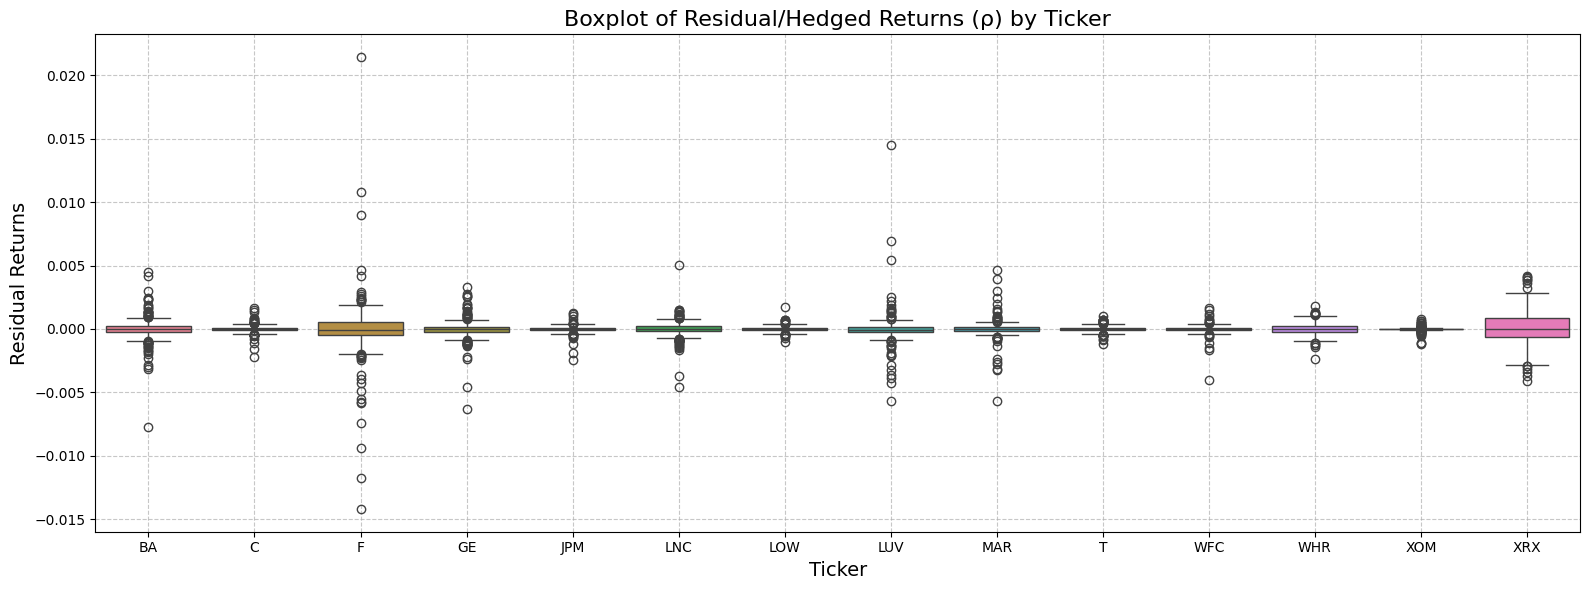

In [12]:
# Create a boxplot of the residual returns for all tickers
plt.figure(figsize=(16, 6))
sns.boxplot(data=residual_returns)
plt.title('Boxplot of Residual/Hedged Returns (ρ) by Ticker', fontsize=16)
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Residual Returns', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Key Observations**:
1. **Fat-tailed distributions** of hedged CDS returns $\rho$ become more pronounced during crises periods like 2020.  
2. **2020 COVID** saw unusually **large spikes** in $\rho$, linked to sudden changes in credit risk sentiment.  
3. **Ticker-level volatility** can vary drastically; for instance, **F** (Ford) and **LUV** (Southwest Airlines) spike more than others due to significant credit risk in the transportation industry.  
4. **Predicted residual returns** $\hat{\rho}$ share a structure similar to actual $\rho$—confirming that **lagged equity signals** convey valuable information.


## Predictive regressions
- Using the residuals returns $\rho_{E,n}$ for all equities and weeks, I create predictive regression models in exponentially decaying and boxcar OLS regressions without intercept. 
- I estimate the following model of the residual returns $\rho_{E,n}$ using last week residual equity return. $\rho_{E,n} = c_{E,n-1} + \epsilon$
- Then, I also calculate the residuals of the predictive model. $q_{E,n} = \rho_{E,n} - \mu_{E,n}c_{E,n-1}$

In [13]:
# --- Parameters ---
G = 20   # Rolling window size (weeks)
H = 10   # Half-life (weeks) for exponential decay weights

# Dictionaries to store the predicted values and residuals for each ticker.
pred_boxcar_dict = {}
resid_boxcar_dict = {}
pred_dls_dict = {}
resid_dls_dict = {}

for ticker in tickers:
    y = residual_returns[ticker]
    predictor = residual_equity_returns[ticker].shift(1)
    
    # Align the two series: use only dates where both are available.
    common_dates = y.dropna().index.intersection(predictor.dropna().index)
    y = y.loc[common_dates]
    predictor = predictor.loc[common_dates]
    
    # -----------------------------------------------------
    # (A) Boxcar OLS Regression (Uniform Weights)
    # Compute regression coefficients (mu) using your rolling_regression function.
    mu_box, _, _ = rolling_regression(
        y=y,
        X=predictor.values.reshape(-1, 1),
        window=G,
        add_const=False,
        return_preds=False,
        return_resid=False
    )
    # Assume rolling_regression returns an array with the same length as y,
    # with the first G-1 rows invalid. Then the valid coefficients are:
    if hasattr(mu_box, 'iloc'):
        mu_box_valid = mu_box.iloc[G-1:, 0].values
    else:
        mu_box_valid = mu_box[G-1:, 0]
    
    # Define the valid dates for boxcar using the length of mu_box_valid.
    n_valid_boxcar = len(mu_box_valid)
    valid_dates_boxcar = y.index[-n_valid_boxcar:]
    
    # Compute predictions: coefficient * current predictor value.
    box_pred = mu_box_valid * predictor.loc[valid_dates_boxcar].values
    # Compute residuals: actual ρ minus predicted ρ.
    box_resid = y.loc[valid_dates_boxcar].values - box_pred
    
    pred_boxcar_dict[ticker] = pd.Series(box_pred, index=valid_dates_boxcar, name=ticker)
    resid_boxcar_dict[ticker] = pd.Series(box_resid, index=valid_dates_boxcar, name=ticker)
    
    # -----------------------------------------------------
    # (B) Exponentially Decaying Regression (Discounted LS)
    # Compute regression coefficients (mu) using discounted LS.
    mu_dls, _, _ = rolling_discounted_least_squares(
        y=y.to_numpy(),
        X=predictor.to_numpy().reshape(-1, 1),
        window=G,
        half_life=H,
        add_const=False,
        return_preds=False,
        return_resid=False
    )
    # For discounted LS, the function may return fewer rows.
    if hasattr(mu_dls, 'iloc'):
        mu_dls_valid = mu_dls.iloc[G-1:, 0].values
    else:
        mu_dls_valid = mu_dls[G-1:, 0]
    
    # Define the valid dates for discounted LS using its length.
    n_valid_dls = len(mu_dls_valid)
    valid_dates_dls = y.index[-n_valid_dls:]
    
    dls_pred = mu_dls_valid * predictor.loc[valid_dates_dls].values
    dls_resid = y.loc[valid_dates_dls].values - dls_pred
    
    pred_dls_dict[ticker] = pd.Series(dls_pred, index=valid_dates_dls, name=ticker)
    resid_dls_dict[ticker] = pd.Series(dls_resid, index=valid_dates_dls, name=ticker)

# Predicted values (ρ) using Boxcar OLS.
df_pred_boxcar = pd.concat(pred_boxcar_dict, axis=1)
# Residuals from Boxcar OLS.
df_resid_boxcar = pd.concat(resid_boxcar_dict, axis=1)

# Predicted values (ρ) using Exponentially Decaying Regression.
df_pred_dls = pd.concat(pred_dls_dict, axis=1)
# Residuals from Exponentially Decaying Regression.
df_resid_dls = pd.concat(resid_dls_dict, axis=1)


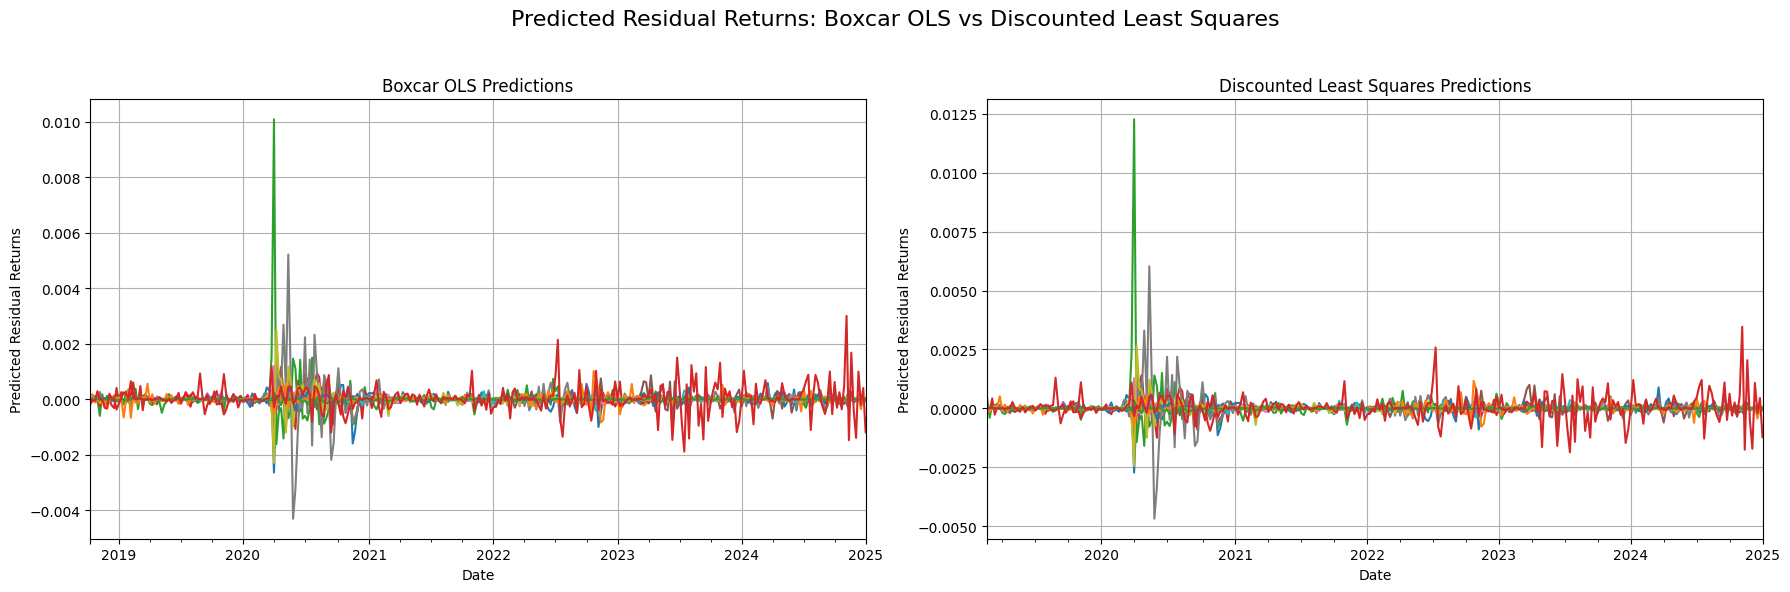

In [14]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot df_pred_boxcar
df_pred_boxcar.plot(ax=axes[0], legend=False)
axes[0].set_title('Boxcar OLS Predictions')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Predicted Residual Returns')
axes[0].grid(True)

# Plot df_pred_dls
df_pred_dls.plot(ax=axes[1], legend=False)
axes[1].set_title('Discounted Least Squares Predictions')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Predicted Residual Returns')
axes[1].grid(True)

# Set the main title for the figure
fig.suptitle('Predicted Residual Returns: Boxcar OLS vs Discounted Least Squares', fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

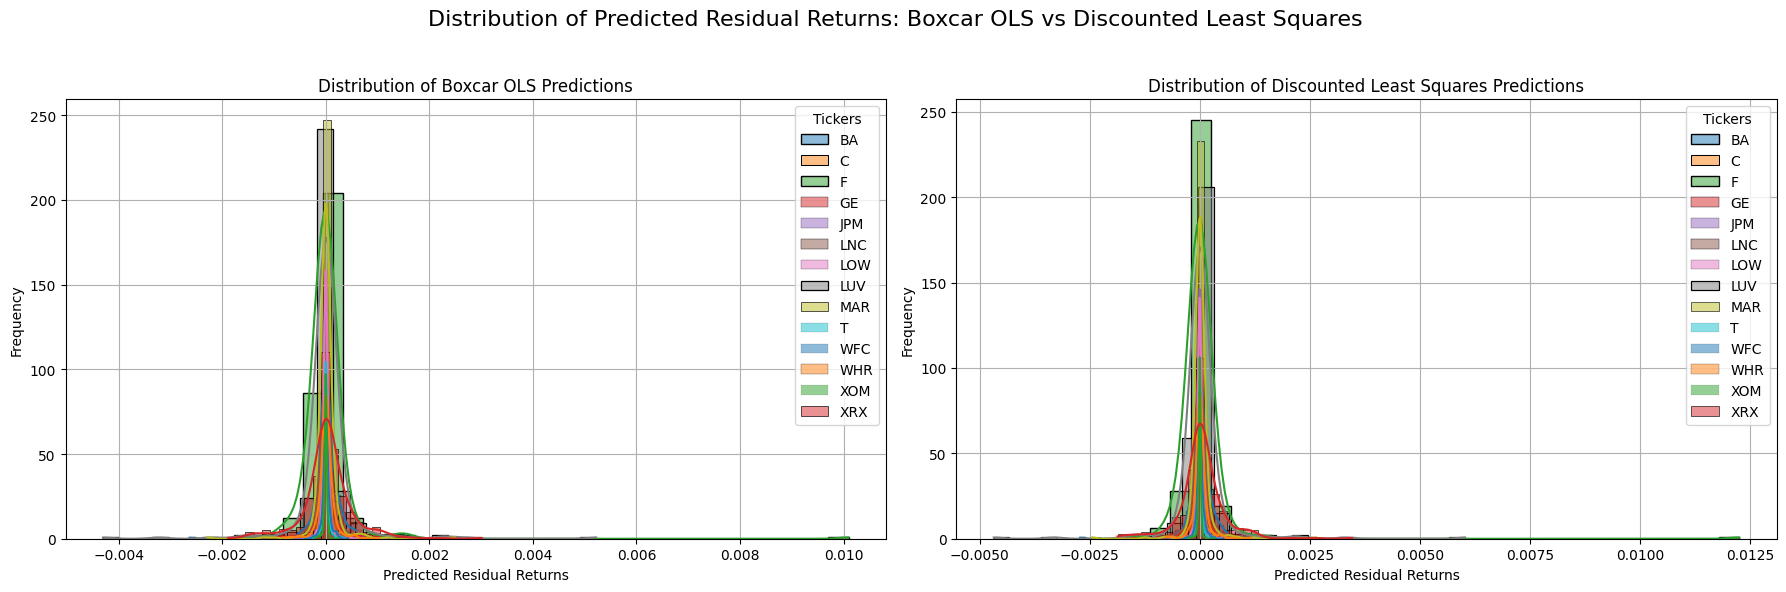

In [15]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot the distribution of pred_boxcar
for ticker in pred_boxcar_dict.keys():
    sns.histplot(pred_boxcar_dict[ticker], bins=30, kde=True, ax=axes[0], label=ticker, alpha=0.5)

axes[0].set_title('Distribution of Boxcar OLS Predictions')
axes[0].set_xlabel('Predicted Residual Returns')
axes[0].set_ylabel('Frequency')
axes[0].legend(title='Tickers')
axes[0].grid(True)

# Plot the distribution of pred_dls
for ticker in pred_dls_dict.keys():
    sns.histplot(pred_dls_dict[ticker], bins=30, kde=True, ax=axes[1], label=ticker, alpha=0.5)

axes[1].set_title('Distribution of Discounted Least Squares Predictions')
axes[1].set_xlabel('Predicted Residual Returns')
axes[1].set_ylabel('Frequency')
axes[1].legend(title='Tickers')
axes[1].grid(True)

# Set the main title for the figure
fig.suptitle('Distribution of Predicted Residual Returns: Boxcar OLS vs Discounted Least Squares', fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

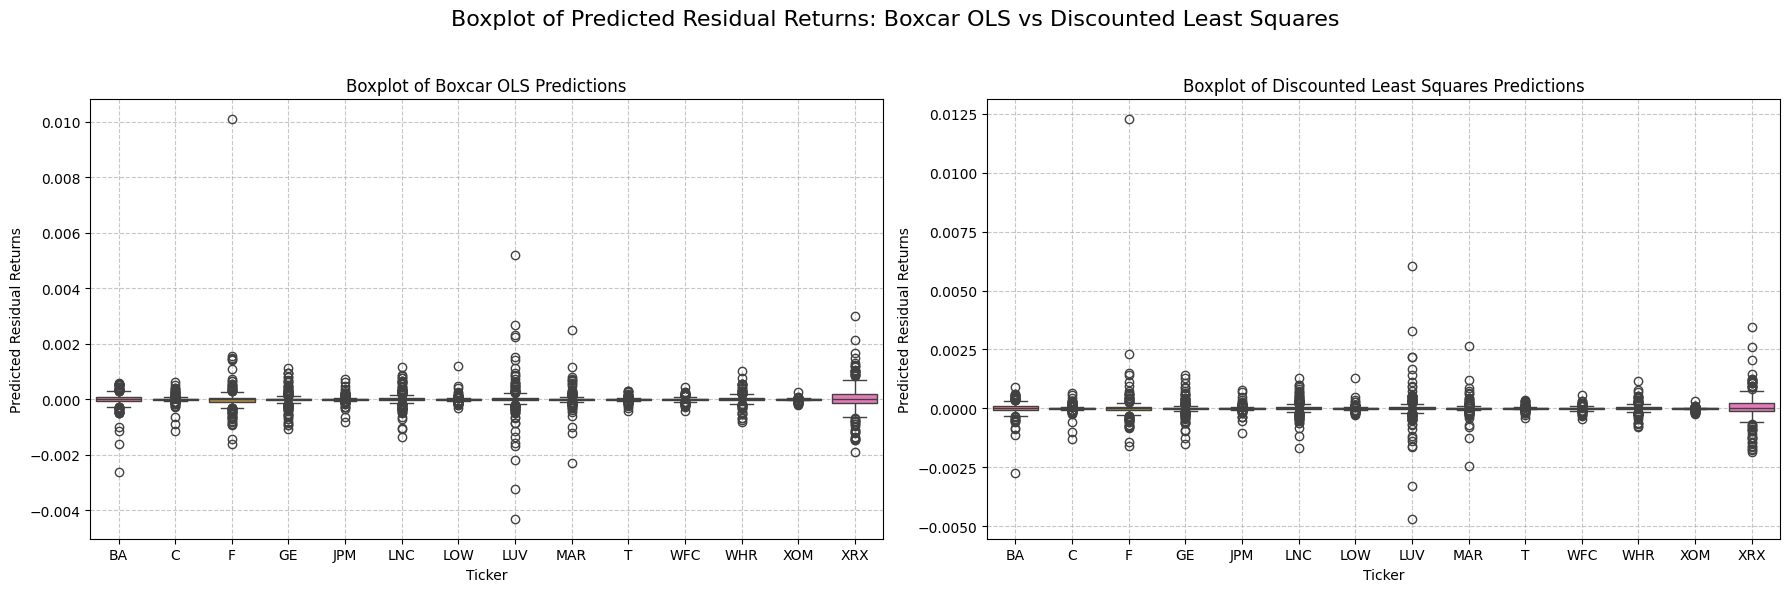

In [16]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Boxplot for pred_boxcar
sns.boxplot(data=pd.DataFrame(pred_boxcar_dict), ax=axes[0])
axes[0].set_title('Boxplot of Boxcar OLS Predictions')
axes[0].set_xlabel('Ticker')
axes[0].set_ylabel('Predicted Residual Returns')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Boxplot for pred_dls
sns.boxplot(data=pd.DataFrame(pred_dls_dict), ax=axes[1])
axes[1].set_title('Boxplot of Discounted Least Squares Predictions')
axes[1].set_xlabel('Ticker')
axes[1].set_ylabel('Predicted Residual Returns')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Set the main title for the figure
fig.suptitle('Boxplot of Predicted Residual Returns: Boxcar OLS vs Discounted Least Squares', fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Key Observations

- The histogram shows that **residual CDS returns are centered around zero**, with a relatively **symmetrical distribution**.
- Different tickers exhibit **varying levels of dispersion**, indicating **differences in risk exposure**.
- **No clear trend or drift** is present, confirming that the residuals are mean-reverting.
- Periods of **higher volatility** are visible, suggesting that **market conditions impact idiosyncratic risk differently over time**.
- Both **Boxcar OLS and DLS deliver comparable predictive accuracy**, as seen in the alignment between the Boxcar and Discounted Least Squares figures


## Trading Strategy Construction
The trading strategy is based on a **predictive regression model** that forecasts **hedged CDS returns** using **lagged residual equity returns**. The key steps are:

1. **Signal Generation: Predicting Hedged CDS Returns**
   - A regression model is built where **hedged CDS residual returns (ρ)** are predicted using **lagged residual equity returns (c)**.
   - This predictive regression provides an **estimated residual return**, which serves as a trading signal.

2. **Percentile-Based Signal Processing**
   - The predicted residual returns are ranked cross-sectionally across CDS contracts.
   - **Percentiles of the estimated residuals** are calculated to define trading signals.

3. **Portfolio Execution Based on Quantile Signals**
   - **Long positions** are taken in CDS contracts where the predicted return is in the **upper quantile**.
   - **Short positions** are taken in CDS contracts where the predicted return is in the **lower quantile**.
   - Positions are updated dynamically as new predictions are generated.

---

**Performance Evaluation**
To evaluate the robustness of the strategy, performance is tested in four steps:

1. **Baseline Quantile Strategy (60/40 Split)**
   - The strategy is initially tested with a **60th percentile long threshold** and **40th percentile short threshold**.
   - This provides a reference performance level.

2. **Comparison: Boxcar OLS vs. Exponentially Discounted Regression**
   - The performance of the strategy is tested using the same Baseline Quantile Strategy, but the focus is in the difference between Boxcar OLS and Exponentially decaying regression:
     - **Boxcar OLS**, which applies equal weighting over a fixed window.
     - **Exponentially Decaying Regression**, which gives more weight to recent observations.
   - The goal is to determine which method **provides better predictive accuracy**.

3. **Sensitivity Analysis of Quantile Thresholds**
   - The 60/40 split is adjusted to different percentile thresholds to **analyze the impact of varying quantiles** on performance.
   - This helps identify the **optimal quantile selection** for maximizing returns.

4. **Impact of Varying G (Window Size) and H (Half-Life for Discounting)**
   - The predictive regression is tested under **different values of G (Boxcar window size)** and **H (half-life for exponential weighting)**.
   - This helps determine:
     - How **long-term vs. short-term history** impacts forecasting performance.
     - Whether **a faster decay rate (lower H) improves responsiveness** or whether **longer memory (higher H) stabilizes predictions**.



## Baseline Quantile Strategy

In [17]:
# Align the indices.
common_index = df_pred_boxcar.index.intersection(df_pred_dls.index).intersection(residual_returns.index)
df_pred_boxcar_aligned = df_pred_boxcar.loc[common_index]
df_pred_dls_aligned = df_pred_dls.loc[common_index]
resid_aligned = residual_returns.loc[common_index]

# Define quantile thresholds (60% and 40%)
q_up = 0.60
q_low = 0.40

# Compute signals for both methods.
signals_box = compute_signals(df_pred_boxcar_aligned, q_up, q_low)
signals_dls = compute_signals(df_pred_dls_aligned, q_up, q_low)

# Compute per-ticker strategy returns.
# Strategy return = signal * actual residual return.
strat_returns_box = signals_box * resid_aligned
strat_returns_dls = signals_dls * resid_aligned

# Compute cumulative returns for each ticker.
cumulative_box = (1 + strat_returns_box).cumprod() - 1
cumulative_dls = (1 + strat_returns_dls).cumprod() - 1

# Get list of tickers.
tickers_list = df_pred_boxcar_aligned.columns.tolist()

metrics_box = calculate_return_metrics(strat_returns_box, adj=52, adjusted=True, quantile=0.05)
metrics_dls = calculate_return_metrics(strat_returns_dls, adj=52, adjusted=True, quantile=0.05)
print("Performance Metrics: Boxcar OLS Strategy")
metrics_box

Performance Metrics: Boxcar OLS Strategy


,Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,VaR (0.05),Max Drawdown,Excess Kurtosis,Annualized Sortino Ratio
BA,0.00884,0.00526,1.68114,1.69219,-0.00071,-0.00320,9.21696,2.82895
C,0.00230,0.00190,1.20943,3.22168,-0.00027,-0.00140,21.20008,2.35330
F,0.01564,0.01604,0.97497,4.15553,-0.00138,-0.01078,36.55489,1.67549
GE,0.00518,0.00501,1.03357,2.17296,-0.00065,-0.00659,28.87973,1.42580
JPM,0.00245,0.00195,1.25587,3.57484,-0.00027,-0.00148,29.24810,2.11610
LNC,0.00656,0.00450,1.45808,3.32114,-0.00061,-0.00385,23.02580,2.83937
LOW,0.00275,0.00139,1.97307,2.76974,-0.00016,-0.00076,20.67125,3.63387
LUV,0.01200,0.00834,1.43908,7.05388,-0.00046,-0.00429,81.99378,2.96328
MAR,0.00280,0.00512,0.54566,-0.76297,-0.00040,-0.01177,26.60989,0.48759
T,0.00128,0.00146,0.87765,0.06944,-0.00028,-0.00404,3.45501,1.11541


In [18]:
print("\nPerformance Metrics: Discounted LS Strategy")
metrics_dls


Performance Metrics: Discounted LS Strategy


,Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,VaR (0.05),Max Drawdown,Excess Kurtosis,Annualized Sortino Ratio
BA,0.01174,0.00618,1.90089,3.18152,-0.00069,-0.00302,23.17043,3.53262
C,0.00319,0.00187,1.70045,3.33650,-0.00027,-0.00125,21.51582,3.50869
F,0.01987,0.01599,1.24293,4.09549,-0.00116,-0.01078,36.45047,2.01493
GE,0.00634,0.00502,1.26325,2.11058,-0.00063,-0.00582,28.45389,1.71894
JPM,0.00253,0.00195,1.30107,3.69273,-0.00024,-0.00153,29.81518,2.26835
LNC,0.00714,0.00448,1.59378,3.31740,-0.00057,-0.00285,23.11097,3.09764
LOW,0.00275,0.00139,1.97567,2.82265,-0.00016,-0.00076,20.83614,3.77393
LUV,0.01242,0.00833,1.49184,7.06345,-0.00043,-0.00429,82.22223,3.03345
MAR,0.00379,0.00511,0.74167,-0.58083,-0.00039,-0.01017,26.79698,0.68471
T,0.00156,0.00141,1.11086,-0.18846,-0.00027,-0.00256,4.03334,1.27462


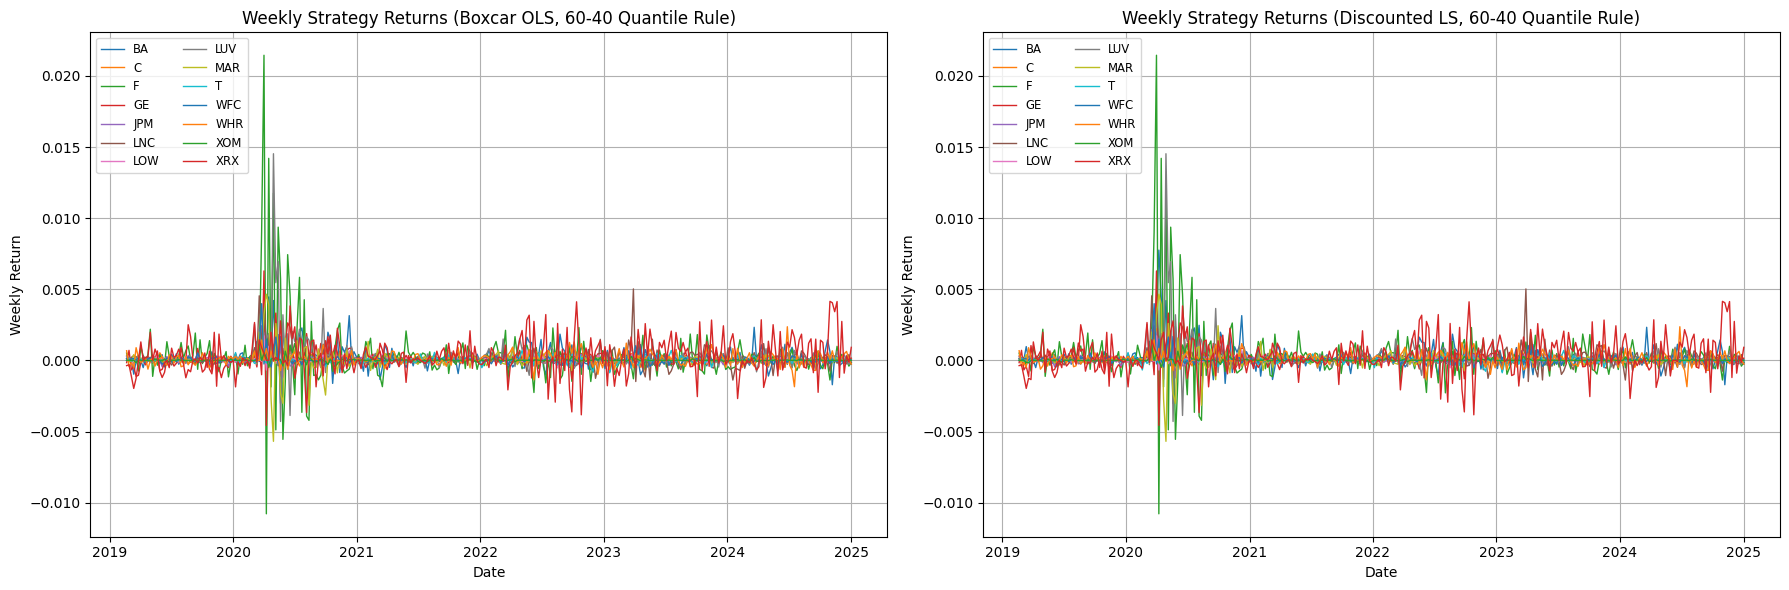

In [19]:
# ============================================================================
# FIGURE: Weekly Strategy Returns (Line Plot) – Boxcar OLS vs Discounted LS
# ============================================================================

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot for Boxcar OLS
for ticker in tickers_list:
    axes[0].plot(strat_returns_box.index, strat_returns_box[ticker], lw=1, label=ticker)
axes[0].set_title("Weekly Strategy Returns (Boxcar OLS, 60-40 Quantile Rule)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Weekly Return")
axes[0].legend(loc='upper left', fontsize='small', ncol=2)
axes[0].grid(True)

# Plot for Discounted LS
for ticker in tickers_list:
    axes[1].plot(strat_returns_dls.index, strat_returns_dls[ticker], lw=1, label=ticker)
axes[1].set_title("Weekly Strategy Returns (Discounted LS, 60-40 Quantile Rule)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Weekly Return")
axes[1].legend(loc='upper left', fontsize='small', ncol=2)
axes[1].grid(True)

plt.tight_layout()
plt.show()


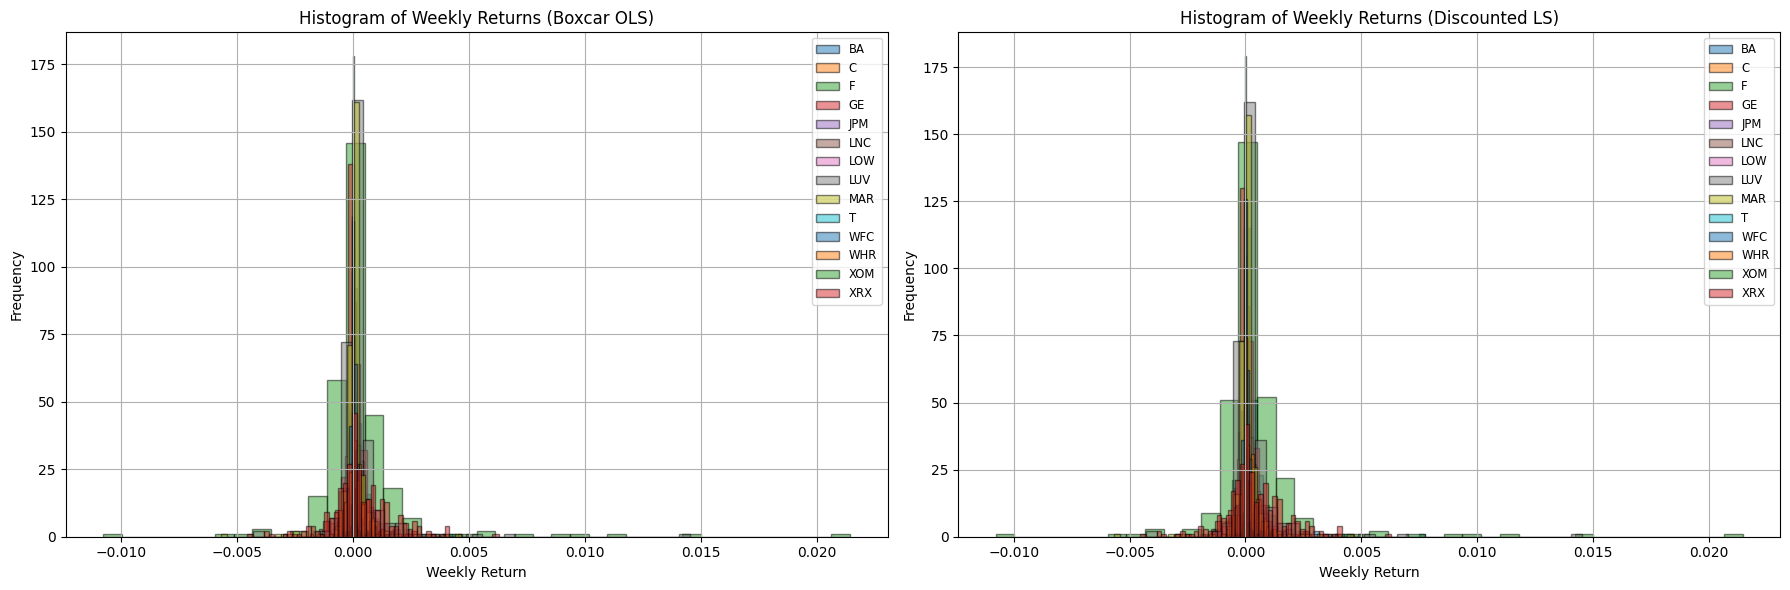

In [20]:
# ============================================================================
# FIGURE 3 & 4: Histogram of Weekly Strategy Returns – Boxcar OLS & Discounted LS
# ============================================================================

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Histogram for Boxcar OLS
for ticker in tickers_list:
    axes[0].hist(strat_returns_box[ticker].dropna(), bins=40, alpha=0.5, label=ticker, edgecolor='black')
axes[0].set_title("Histogram of Weekly Returns (Boxcar OLS)")
axes[0].set_xlabel("Weekly Return")
axes[0].set_ylabel("Frequency")
axes[0].legend(fontsize='small')
axes[0].grid(True)

# Histogram for Discounted LS
for ticker in tickers_list:
    axes[1].hist(strat_returns_dls[ticker].dropna(), bins=40, alpha=0.5, label=ticker, edgecolor='black')
axes[1].set_title("Histogram of Weekly Returns (Discounted LS)")
axes[1].set_xlabel("Weekly Return")
axes[1].set_ylabel("Frequency")
axes[1].legend(fontsize='small')
axes[1].grid(True)

plt.tight_layout()
plt.show()

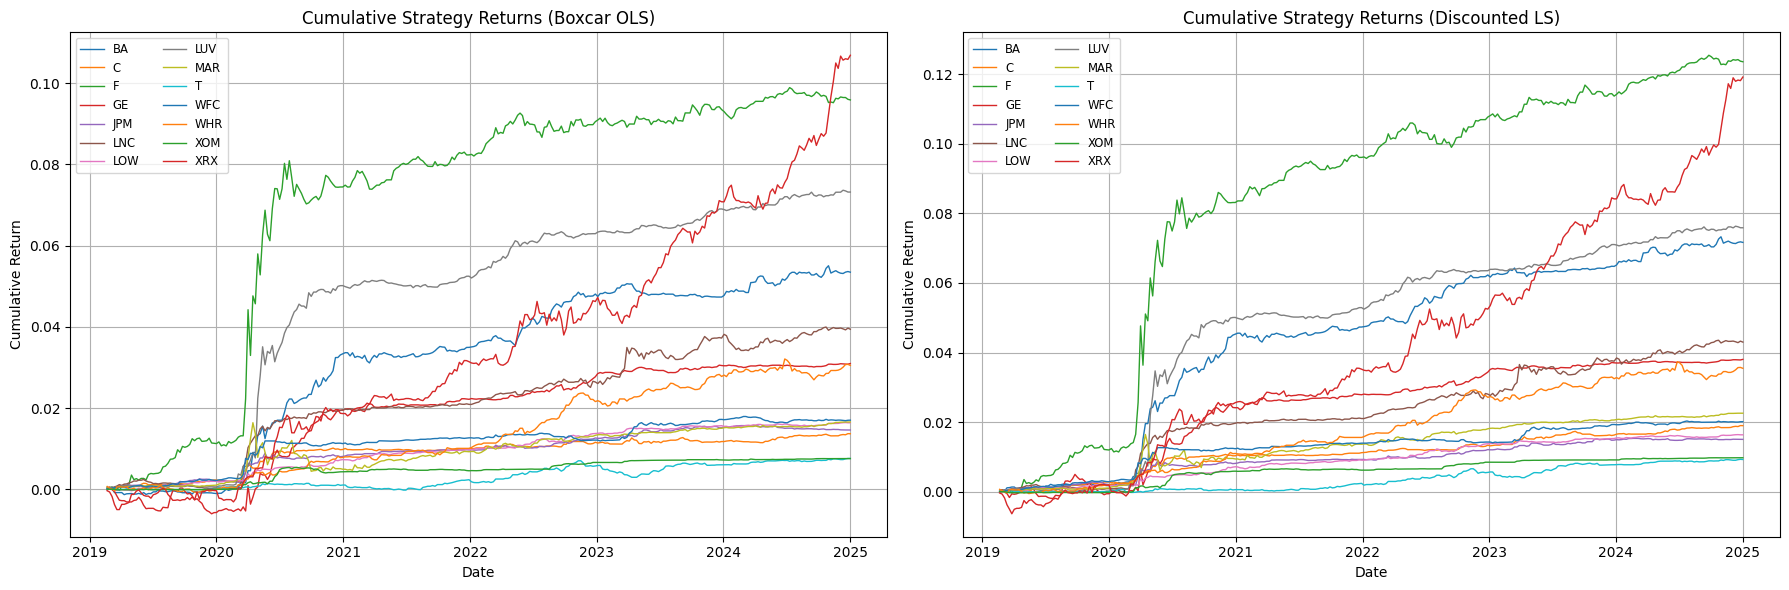

In [21]:
# ============================================================================
# FIGURE: Cumulative Strategy Returns – Boxcar OLS vs Discounted LS
# ============================================================================

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot for Boxcar OLS
for ticker in tickers_list:
    axes[0].plot(cumulative_box.index, cumulative_box[ticker], lw=1, label=ticker)
axes[0].set_title("Cumulative Strategy Returns (Boxcar OLS)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cumulative Return")
axes[0].legend(loc='upper left', fontsize='small', ncol=2)
axes[0].grid(True)

# Plot for Discounted LS
for ticker in tickers_list:
    axes[1].plot(cumulative_dls.index, cumulative_dls[ticker], lw=1, label=ticker)
axes[1].set_title("Cumulative Strategy Returns (Discounted LS)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Cumulative Return")
axes[1].legend(loc='upper left', fontsize='small', ncol=2)
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Boxcar OLS vs Exponentially Decaying Least Squares

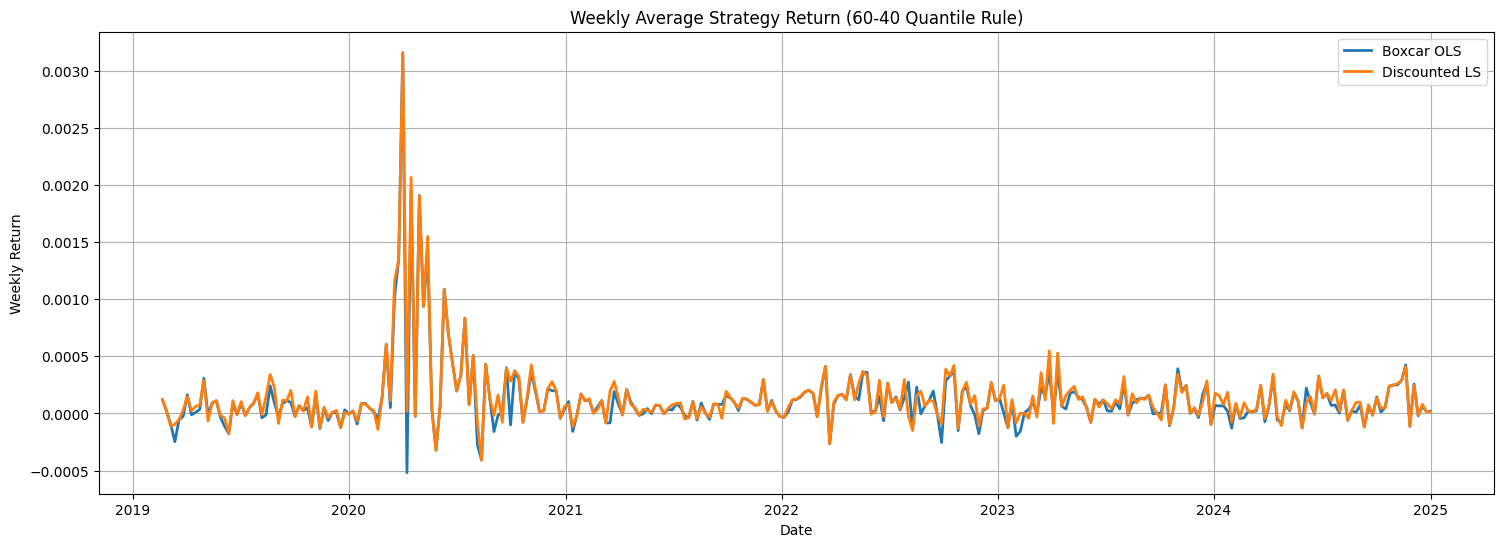

In [22]:
# Align the date indices.
common_index = df_pred_boxcar.index.intersection(df_pred_dls.index).intersection(residual_returns.index)
df_pred_boxcar_aligned = df_pred_boxcar.loc[common_index]
df_pred_dls_aligned = df_pred_dls.loc[common_index]
resid_aligned = residual_returns.loc[common_index]

# Define the quantile pair: 60-40.
q_upper = 0.60
q_lower = 0.40

# ----------------------------------------------------------------
# Compute weekly strategy returns for each method using the 60-40 quantile rule.
# ----------------------------------------------------------------
weekly_strategy_box = compute_quantile_strategy_returns(df_pred_boxcar_aligned, resid_aligned, q_upper, q_lower)
weekly_strategy_dls = compute_quantile_strategy_returns(df_pred_dls_aligned, resid_aligned, q_upper, q_lower)

# ----------------------------------------------------------------
# Graph 1: Weekly Average Strategy Return (Line Plot)
# Plot the weekly average strategy return for Boxcar OLS and Discounted LS.
# ----------------------------------------------------------------
plt.figure(figsize=(18,6))
plt.plot(weekly_strategy_box.index, weekly_strategy_box, label='Boxcar OLS', lw=2)
plt.plot(weekly_strategy_dls.index, weekly_strategy_dls, label='Discounted LS', lw=2)
plt.title("Weekly Average Strategy Return (60-40 Quantile Rule)")
plt.xlabel("Date")
plt.ylabel("Weekly Return")
plt.legend()
plt.grid(True)
plt.show()


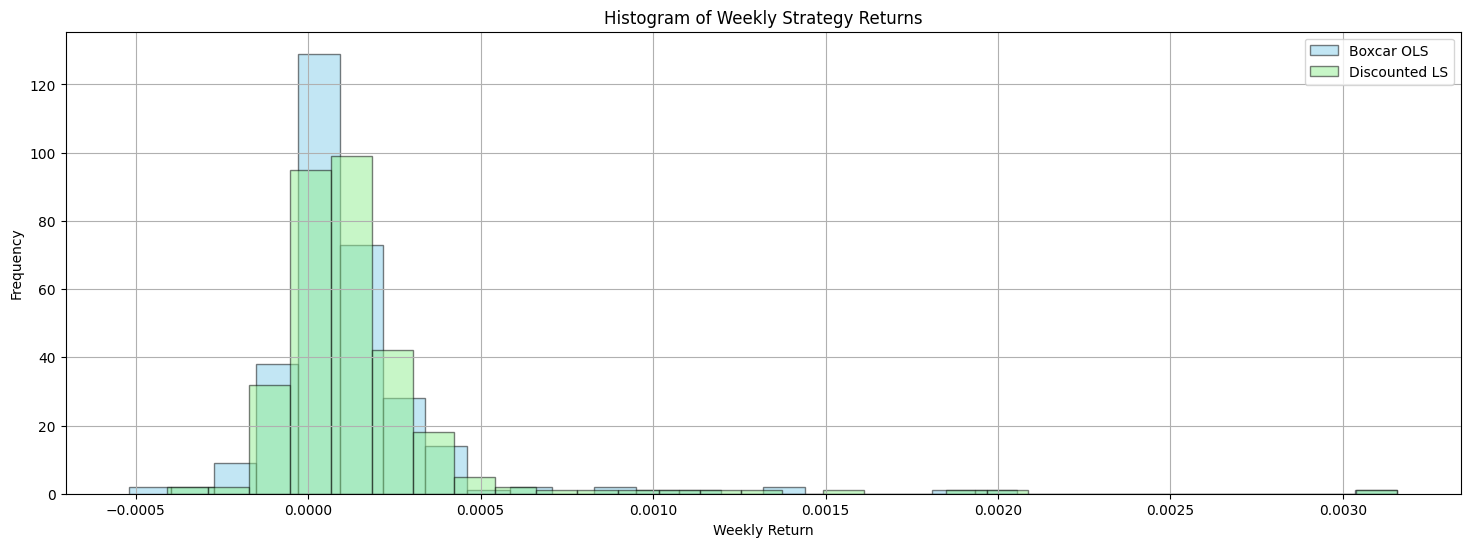

In [23]:
# ----------------------------------------------------------------
# Graph 2: Histogram of Weekly Strategy Returns
# Produce side-by-side histograms for Boxcar OLS and Discounted LS.
# ----------------------------------------------------------------
plt.figure(figsize=(18,6))
plt.hist(weekly_strategy_box.dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.5, label='Boxcar OLS')
plt.hist(weekly_strategy_dls.dropna(), bins=30, color='lightgreen', edgecolor='black', alpha=0.5, label='Discounted LS')
plt.title("Histogram of Weekly Strategy Returns")
plt.xlabel("Weekly Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

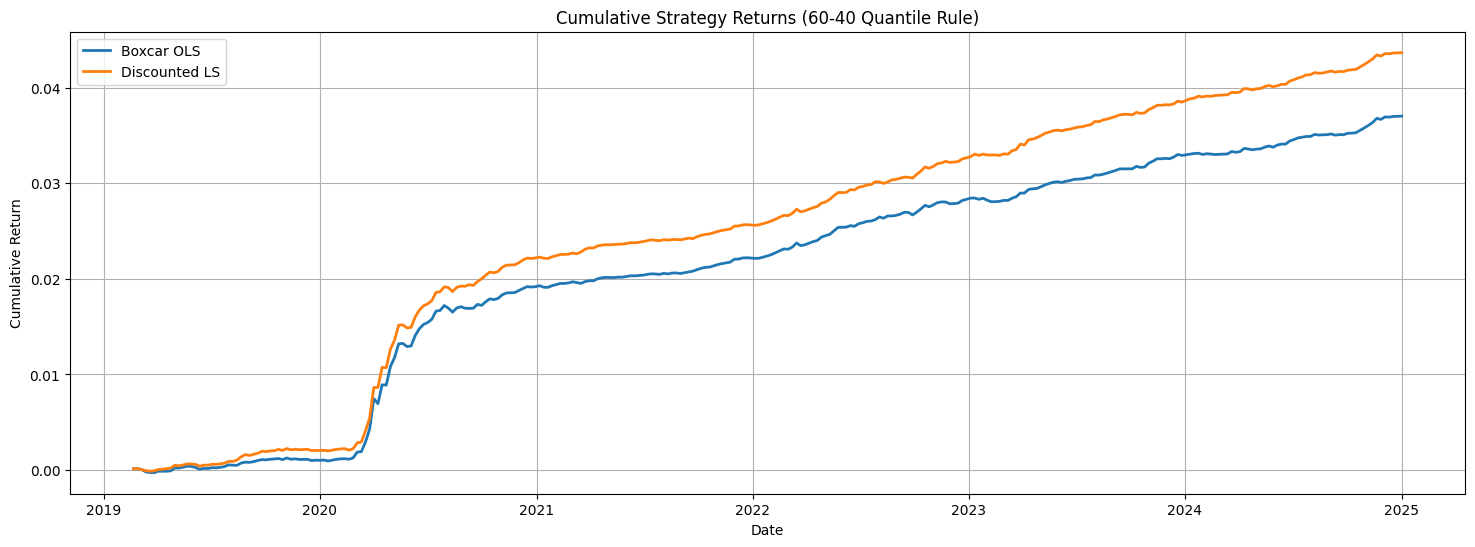

In [24]:
# ----------------------------------------------------------------
# Graph 3: Cumulative Strategy Returns
# Compute cumulative returns and plot both methods on the same graph.
# ----------------------------------------------------------------
cumulative_box = (1 + weekly_strategy_box).cumprod() -1
cumulative_dls = (1 + weekly_strategy_dls).cumprod() -1

plt.figure(figsize=(18,6))
plt.plot(cumulative_box.index, cumulative_box, label='Boxcar OLS', lw=2)
plt.plot(cumulative_dls.index, cumulative_dls, label='Discounted LS', lw=2)
plt.title("Cumulative Strategy Returns (60-40 Quantile Rule)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

**Key Takeaways**
- The initial 60th percentile long / 40th percentile short strategy provides a **reasonable starting point** for capturing predictive signals.
- The strategy generates **consistent but moderate** returns, suggesting that **hedged CDS returns can be predicted effectively**.
- Both **Boxcar OLS and Discounted LS** predict well, but **Discounted LS adapts faster** in volatile periods.
- **Boxcar OLS** works well in **stable markets**, but struggles when market conditions shift.
- **DLS performs better when market conditions change rapidly**, as it prioritizes recent data over historical information.
- Overall, **both methods deliver similar results in normal conditions**, but **DLS is more adaptive in dynamic environments**.


## Sensitivity Analysis of Quantiles Thresholds

In [25]:
# Align the date indices.
common_index = df_pred_boxcar.index.intersection(df_pred_dls.index).intersection(residual_returns.index)
df_pred_boxcar_aligned = df_pred_boxcar.loc[common_index]
df_pred_dls_aligned = df_pred_dls.loc[common_index]
resid_aligned = residual_returns.loc[common_index]

# Define six quantile pairs. Each pair is (upper quantile, lower quantile).
# For example, '75-25' means: long if predicted > 75th percentile, short if predicted < 25th percentile.
quantile_pairs = {
    '50-50': (0.50, 0.50),
    '55-45': (0.55, 0.45),
    '60-40': (0.60, 0.40),
    '65-35': (0.65, 0.35),
    '70-30': (0.70, 0.30),
    '75-25': (0.75, 0.25)
}

# Dictionaries to store daily strategy returns.
strat_returns_box = {}
strat_returns_dls = {}

for label, (q_up, q_low) in quantile_pairs.items():
    strat_returns_box[label] = compute_quantile_strategy_returns(df_pred_boxcar_aligned, resid_aligned, q_up, q_low)
    strat_returns_dls[label] = compute_quantile_strategy_returns(df_pred_dls_aligned, resid_aligned, q_up, q_low)

# Compute cumulative returns for each quantile pair.
cum_returns_box = {}
cum_returns_dls = {}
for label in quantile_pairs.keys():
    # We assume that returns are expressed as daily returns.
    cum_returns_box[label] = (1 + strat_returns_box[label]).cumprod() - 1
    cum_returns_dls[label] = (1 + strat_returns_dls[label]).cumprod() - 1

# Convert dictionaries to DataFrames
strat_returns_box_df = pd.DataFrame(strat_returns_box)
strat_returns_dls_df = pd.DataFrame(strat_returns_dls)

metrics_box = calculate_return_metrics(strat_returns_box_df, adj=52, adjusted=True, quantile=0.05)
metrics_dls = calculate_return_metrics(strat_returns_dls_df, adj=52, adjusted=True, quantile=0.05)
print("Performance Metrics: Boxcar OLS Strategy")
metrics_box

Performance Metrics: Boxcar OLS Strategy


,Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,VaR (0.05),Max Drawdown,Excess Kurtosis,Annualized Sortino Ratio
50-50,0.00652,0.00237,2.75699,5.23420,-0.00014,-0.00052,38.25489,12.21121
55-45,0.00616,0.00223,2.76783,5.16019,-0.00013,-0.00069,39.29680,9.00450
60-40,0.00616,0.00223,2.76783,5.16019,-0.00013,-0.00069,39.29680,9.00450
65-35,0.00593,0.00214,2.77255,5.15905,-0.00013,-0.00084,38.75831,9.18063
70-30,0.00554,0.00197,2.81144,4.80397,-0.00014,-0.00077,33.20725,8.81118
75-25,0.00554,0.00197,2.81144,4.80397,-0.00014,-0.00077,33.20725,8.81118


In [26]:
print("\nPerformance Metrics: Discounted LS Strategy")
metrics_dls


Performance Metrics: Discounted LS Strategy


,Annualized Return,Annualized Volatility,Sharpe Ratio,Skewness,VaR (0.05),Max Drawdown,Excess Kurtosis,Annualized Sortino Ratio
50-50,0.00751,0.00235,3.19901,5.21399,-0.00011,-0.00041,38.22508,15.40543
55-45,0.00724,0.00224,3.23652,5.19743,-0.00011,-0.00049,38.57553,14.30734
60-40,0.00724,0.00224,3.23652,5.19743,-0.00011,-0.00049,38.57553,14.30734
65-35,0.00719,0.00213,3.37871,5.16420,-0.00011,-0.00057,38.25018,14.06851
70-30,0.00676,0.00203,3.33539,5.15473,-0.00010,-0.00044,38.38011,12.10570
75-25,0.00676,0.00203,3.33539,5.15473,-0.00010,-0.00044,38.38011,12.10570


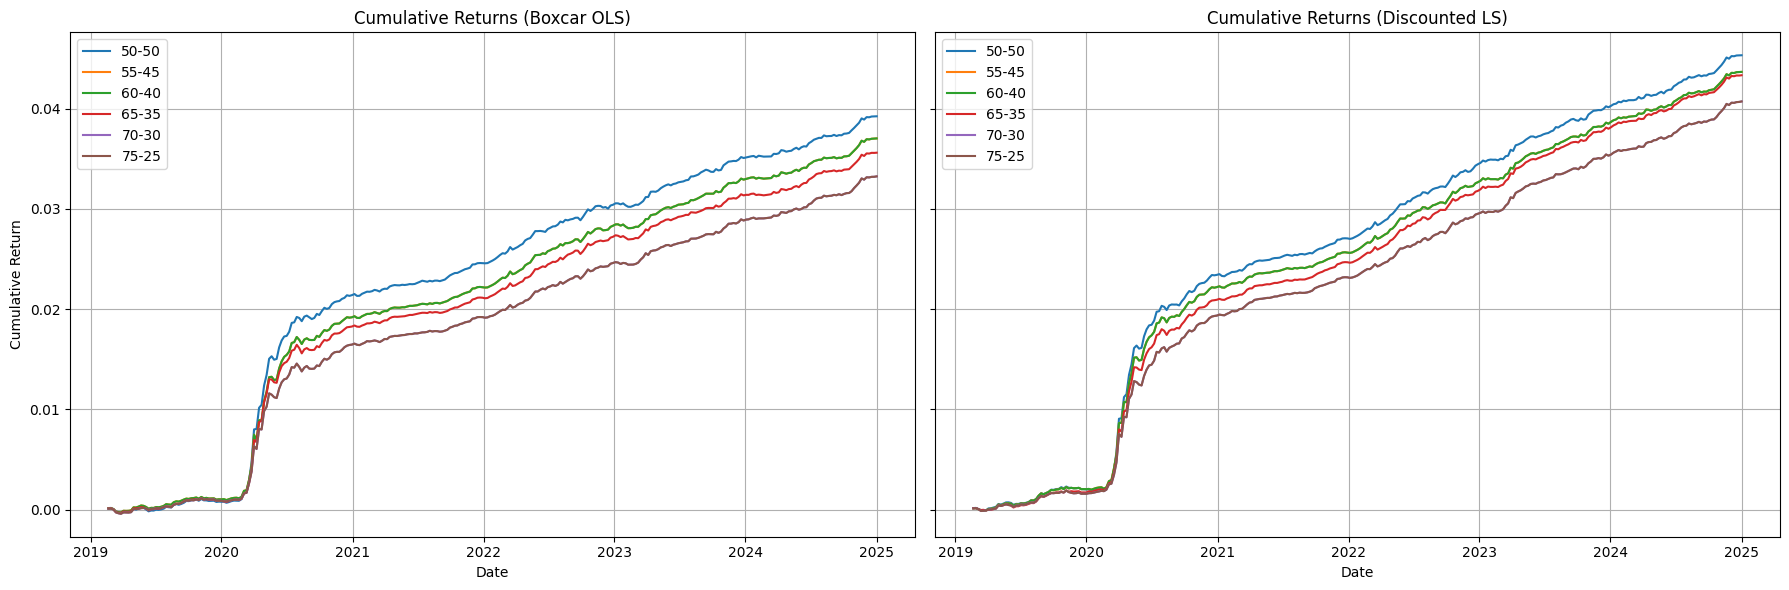

In [27]:
# ----------------------------------------------------------------
# Graph 1: Cumulative Strategy Returns Over Time
# Two subplots: left = Boxcar OLS, right = Discounted LS.
# Each subplot plots one curve per quantile pair.
# ----------------------------------------------------------------

fig, axs = plt.subplots(1, 2, figsize=(18,6), sharey=True)

# Left subplot: Boxcar OLS method.
for label in quantile_pairs.keys():
    axs[0].plot(cum_returns_box[label].index, cum_returns_box[label].values, label=label)
axs[0].set_title("Cumulative Returns (Boxcar OLS)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Cumulative Return")
axs[0].legend()
axs[0].grid(True)

# Right subplot: Discounted LS method.
for label in quantile_pairs.keys():
    axs[1].plot(cum_returns_dls[label].index, cum_returns_dls[label].values, label=label)
axs[1].set_title("Cumulative Returns (Discounted LS)")
axs[1].set_xlabel("Date")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


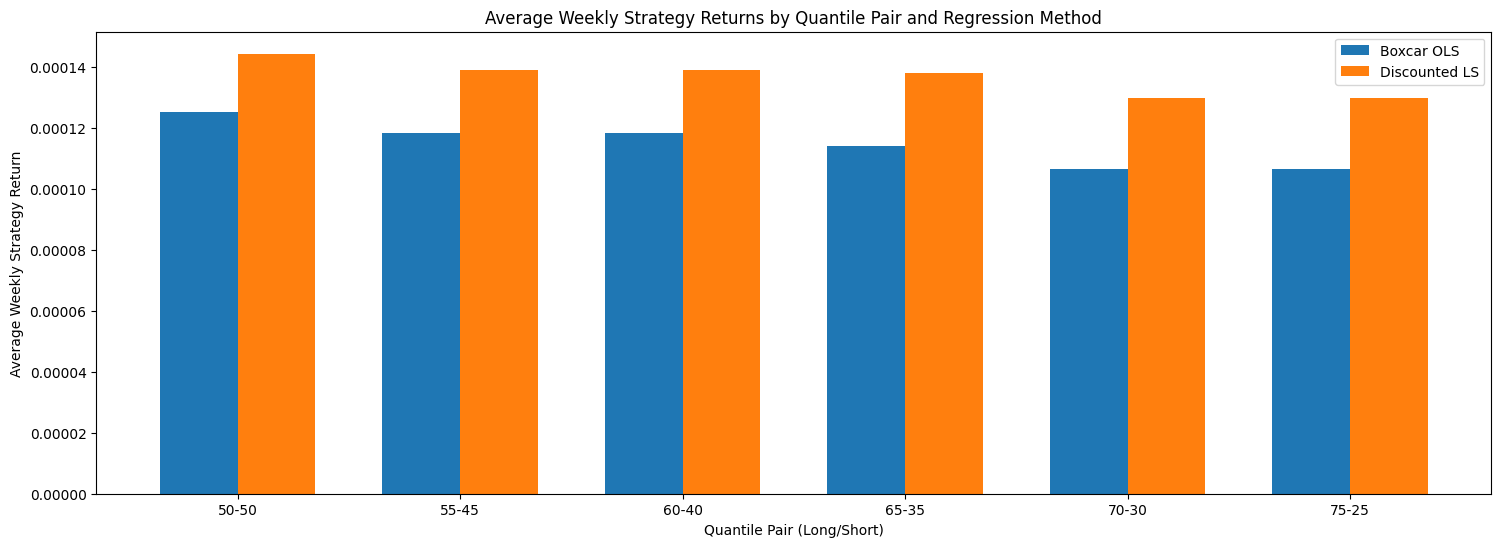

In [28]:
# ----------------------------------------------------------------
# Graph 2: Grouped Bar Chart of Average Daily Strategy Returns.
# For each quantile pair, plot two bars side by side:
# one for Boxcar OLS and one for Discounted LS.
# ----------------------------------------------------------------

# Compute the average daily strategy return (mean over time) for each quantile pair.
avg_returns_box = {label: strat_returns_box[label].mean() for label in quantile_pairs.keys()}
avg_returns_dls = {label: strat_returns_dls[label].mean() for label in quantile_pairs.keys()}

labels = list(quantile_pairs.keys())
x = np.arange(len(labels))  # groups for each quantile pair.
width = 0.35  # width of each bar.

fig, ax = plt.subplots(figsize=(18,6))
bars_box = ax.bar(x - width/2, [avg_returns_box[label] for label in labels], width, label='Boxcar OLS')
bars_dls = ax.bar(x + width/2, [avg_returns_dls[label] for label in labels], width, label='Discounted LS')

ax.set_xlabel("Quantile Pair (Long/Short)")
ax.set_ylabel("Average Weekly Strategy Return")
ax.set_title("Average Weekly Strategy Returns by Quantile Pair and Regression Method")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


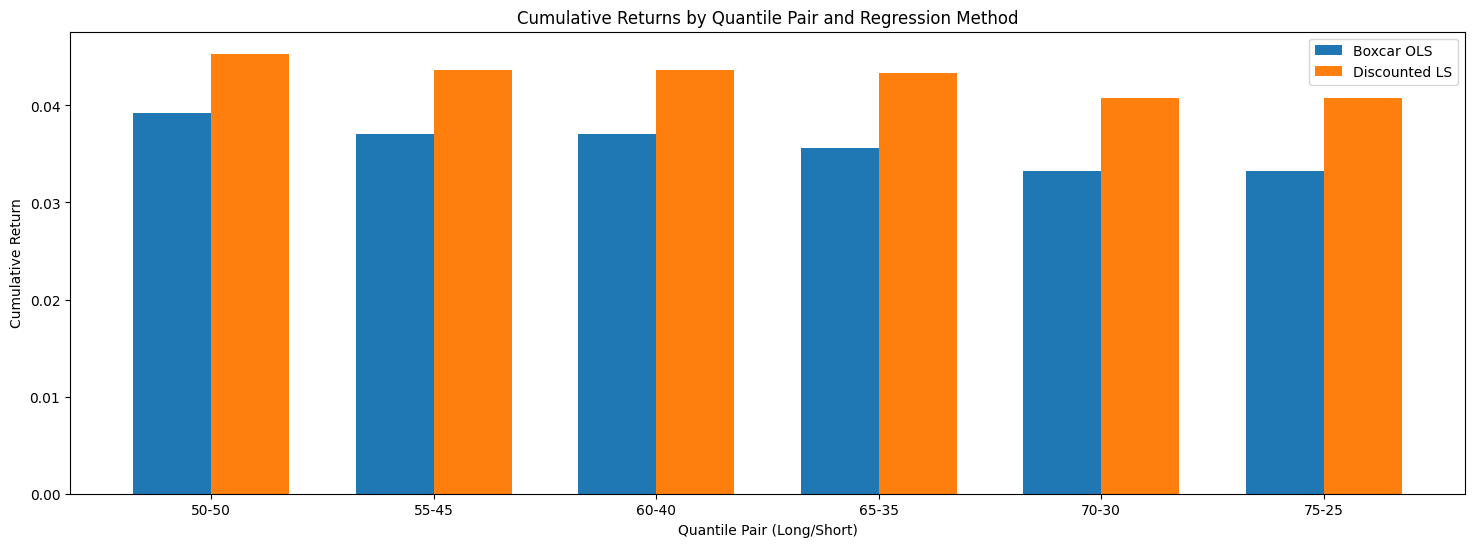

In [29]:
# Compute the final cumulative return for each quantile pair
final_cum_returns_box = {label: cum_returns_box[label].iloc[-1] for label in quantile_pairs.keys()}
final_cum_returns_dls = {label: cum_returns_dls[label].iloc[-1] for label in quantile_pairs.keys()}

# Create a bar chart
labels = list(quantile_pairs.keys())
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(18, 6))
bars_box = ax.bar(x - width/2, [final_cum_returns_box[label] for label in labels], width, label='Boxcar OLS')
bars_dls = ax.bar(x + width/2, [final_cum_returns_dls[label] for label in labels], width, label='Discounted LS')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Quantile Pair (Long/Short)')
ax.set_ylabel('Cumulative Return')
ax.set_title('Cumulative Returns by Quantile Pair and Regression Method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

**Key Takeaways**

- **Stronger quantile cutoffs (e.g., 70/30) result in lower Sharpe ratios**, meaning they increase the risk without significantly improving returns.
- **More conservative quantile splits (e.g., 55/45) actually enhance performance**.
- The **60/40 baseline proves to be a reasonable trade-off**, as increasing the quantile gap too much reduces the **stability of the return spread**.
- This confirms that **selecting quantiles too aggressively can lead to excessive noise**, while a more **balanced selection improves performance consistency**.


### Impact of Varying G (Window Size) and H (Half-Life for Discounting)

In [30]:
boxcar_windows = [10, 15, 20, 25, 30]   # Example window sizes.
dls_half_lives = [5, 7, 10, 12, 15]  # Example half-life values.
G_default = 20  # Fixed window for Discounted LS.

boxcar_metrics = {}
for G in boxcar_windows:
    df_pred_box = compute_strategy_predictions_boxcar(G)
    strat_returns_box = compute_strategy_returns_from_predictions(df_pred_box)
    metrics = calculate_return_metrics(strat_returns_box, adj=52, adjusted=True, quantile=0.05)
    avg_metrics = metrics.mean()
    boxcar_metrics[G] = avg_metrics

df_boxcar_metrics = pd.DataFrame(boxcar_metrics).T

dls_metrics = {}
for H in dls_half_lives:
    df_pred_dls = compute_strategy_predictions_dls(G_default, H)
    strat_returns_dls = compute_strategy_returns_from_predictions(df_pred_dls)
    metrics = calculate_return_metrics(strat_returns_dls, adj=52, adjusted=True, quantile=0.05)
    avg_metrics = metrics.mean()
    dls_metrics[H] = avg_metrics

df_dls_metrics = pd.DataFrame(dls_metrics).T


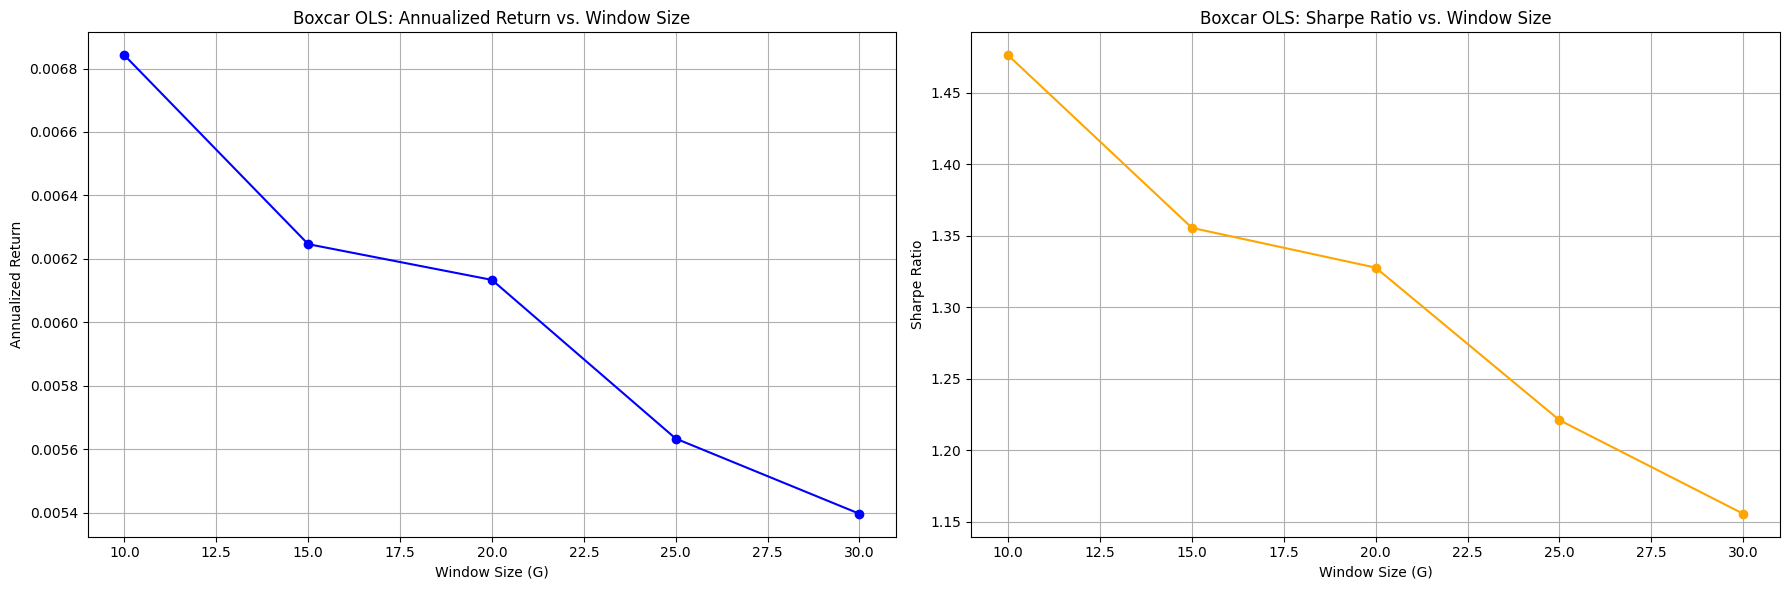

In [31]:
# Boxcar OLS performance plots.
fig, axes = plt.subplots(1, 2, figsize=(18,6))
axes[0].plot(df_boxcar_metrics.index, df_boxcar_metrics['Annualized Return'], marker='o', linestyle='-', color='blue')
axes[0].set_title("Boxcar OLS: Annualized Return vs. Window Size")
axes[0].set_xlabel("Window Size (G)")
axes[0].set_ylabel("Annualized Return")
axes[0].grid(True)
axes[1].plot(df_boxcar_metrics.index, df_boxcar_metrics['Sharpe Ratio'], marker='o', linestyle='-', color='orange')
axes[1].set_title("Boxcar OLS: Sharpe Ratio vs. Window Size")
axes[1].set_xlabel("Window Size (G)")
axes[1].set_ylabel("Sharpe Ratio")
axes[1].grid(True)
plt.tight_layout()
plt.show()

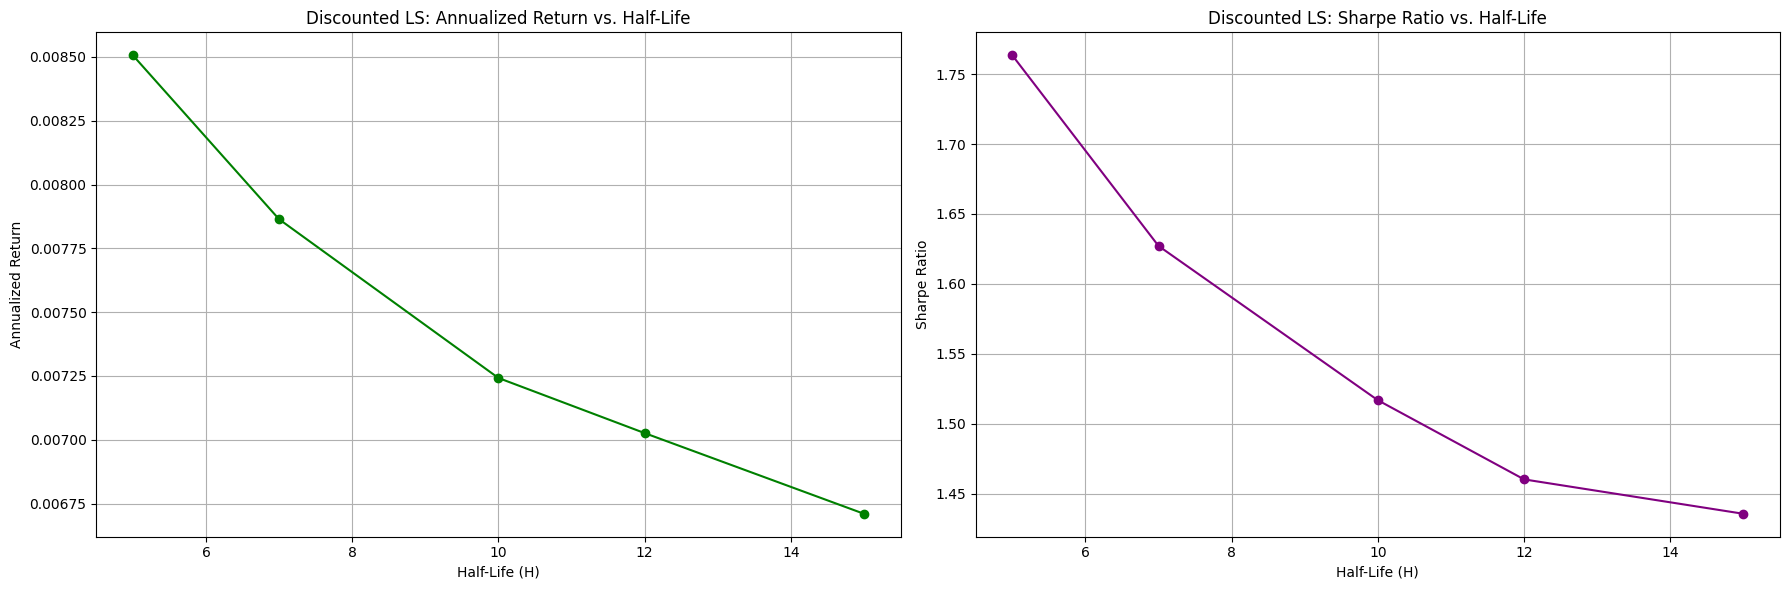

In [32]:
# Discounted LS performance plots.
fig, axes = plt.subplots(1, 2, figsize=(18,6))
axes[0].plot(df_dls_metrics.index, df_dls_metrics['Annualized Return'], marker='o', linestyle='-', color='green')
axes[0].set_title("Discounted LS: Annualized Return vs. Half-Life")
axes[0].set_xlabel("Half-Life (H)")
axes[0].set_ylabel("Annualized Return")
axes[0].grid(True)
axes[1].plot(df_dls_metrics.index, df_dls_metrics['Sharpe Ratio'], marker='o', linestyle='-', color='purple')
axes[1].set_title("Discounted LS: Sharpe Ratio vs. Half-Life")
axes[1].set_xlabel("Half-Life (H)")
axes[1].set_ylabel("Sharpe Ratio")
axes[1].grid(True)
plt.tight_layout()
plt.show()

In [33]:
print("Boxcar OLS Performance Metrics (averaged across tickers):")
df_boxcar_metrics.T

Boxcar OLS Performance Metrics (averaged across tickers):


,10,15,20,25,30
Annualized Return,0.00684,0.00625,0.00613,0.00563,0.00540
Annualized Volatility,0.00467,0.00467,0.00471,0.00475,0.00476
Sharpe Ratio,1.47605,1.35536,1.32754,1.22092,1.15544
Skewness,2.58258,2.84785,2.79303,2.72506,2.70862
VaR (0.05),-0.00052,-0.00056,-0.00056,-0.00057,-0.00058
Max Drawdown,-0.00460,-0.00431,-0.00459,-0.00488,-0.00560
Excess Kurtosis,27.77838,28.23366,27.71055,26.92373,26.78994
Annualized Sortino Ratio,2.40838,2.43233,2.33230,2.18614,1.99877


In [34]:
print("\nDiscounted LS Performance Metrics (averaged across tickers):")
df_dls_metrics.T


Discounted LS Performance Metrics (averaged across tickers):


,5,7,10,12,15
Annualized Return,0.00851,0.00786,0.00724,0.00703,0.00671
Annualized Volatility,0.00480,0.00482,0.00482,0.00482,0.00477
Sharpe Ratio,1.76346,1.62713,1.51682,1.46022,1.43562
Skewness,2.90745,2.87522,2.87268,2.85497,2.75339
VaR (0.05),-0.00047,-0.00049,-0.00053,-0.00054,-0.00055
Max Drawdown,-0.00387,-0.00400,-0.00411,-0.00417,-0.00437
Excess Kurtosis,28.27317,27.80901,28.29401,28.24600,27.09132
Annualized Sortino Ratio,3.13134,2.93491,2.71267,2.60097,2.53806


**Key Takeaways**
- **Shorter windows (low G) and shorter half-lives (low H)** make the model **more responsive but noisier**.
- **Larger G and H values** smooth predictions but **reduce adaptability to changing market conditions**.
- The optimal **G and H depend on market conditions**:
  - **In stable environments**, larger G and H improve robustness.
  - **In volatile markets**, smaller values of G and H allow for faster adaptation.
- The takeaway: **DLS with a well-tuned H can outperform Boxcar OLS in rapidly changing environments**.


## **Conclusion**
This study examined the **predictability of hedged CDS residual returns using lagged residual equity returns**. The methodology followed a **two-stage regression approach**, where market-driven factors were first removed through contemporaneous regressions, and then predictive models (Boxcar OLS and Discounted LS) were applied to forecast next-period CDS residual returns.

Through a **four-fold evaluation**, I found that:
- **Residual equity returns provide valuable predictive signals for CDS residuals**, confirming a **lead-lag relationship** between equity and credit markets.
- **Both Boxcar OLS and Discounted LS perform well**, but **DLS is more adaptive** in volatile market conditions.
- **More conservative quantile thresholds (e.g., 55/45) improve Sharpe ratios**, while aggressive quantiles (e.g., 70/30) increase risk without proportional return benefits.
- **Fine-tuning G (window size) and H (half-life) is crucial** to balance stability and responsiveness, depending on market volatility.

These results align with prior research suggesting that **equity markets incorporate firm-specific news faster than credit markets** (Acharya & Johnson, 2007). The findings reinforce that **credit spreads react with a delay to changes in firm risk, which can be systematically exploited for trading strategies**.

## **Potential Improvements**
While the strategy demonstrates good predictive performance, some refinements could enhance its robustness:

1. **Incorporating Macro Factors:**
   - The current model focuses on firm-specific signals. Including macroeconomic indicators (e.g., interest rates, credit spreads, VIX) could improve predictability, especially during crisis periods.

2. **Nonlinear Modeling Approaches:**
   - The current regression framework assumes **a linear relationship** between residual equity returns and CDS residuals. Testing **machine learning models** (such as Random Forests or LSTMs) could capture **nonlinear dependencies** in the data.

3. **Sector-Specific Analysis:**
   - Not all firms exhibit the same lead-lag dynamics. A sector-based approach could **identify industries where the equity-to-CDS predictability is strongest**.

4. **Alternative Discounting Methods:**
   - While **Exponentially Weighted Least Squares (DLS) proved adaptive**, testing **alternative weighting mechanisms (e.g., Kalman Filters)** could provide further improvements in dynamic markets.
